# Logistic Regression Model

## Data Import And Cleaning

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

train_files2 = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

test_files = [ '../../data/cleaned/utah_2019_vineyard.csv', 
               '../../data/cleaned/utah_2019_marina.csv',
               '../../data/cleaned/utah_2019_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
train_dfs2 = lrf.import_df_data(train_files2, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                 float64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(train_dfs2)):
    timestamp = pd.to_datetime(train_dfs2[i]['Time America/Boise UTC-06:00'])
    train_dfs2[i]['timestamp'] = timestamp
    train_dfs2[i]['datetime'] = timestamp
    train_dfs2[i] = train_dfs2[i].set_index('timestamp')
    train_dfs2[i] = train_dfs2[i].drop(columns=['Time America/Boise UTC-06:00'])
train_dfs2[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


In [7]:
#Combine train sets
train_dfs += train_dfs2


In [8]:
train_dfs[3].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 11:15:00,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8,2018-04-11 11:30:00
2018-04-11 11:45:00,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9,2018-04-11 11:45:00
2018-04-11 12:00:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8,2018-04-11 12:00:00
2018-04-11 12:15:00,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8,2018-04-11 12:15:00


In [9]:
# Now to datetime index our 2019 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00


## Import And Clean Weather Data

In [10]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2020.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,MXPN,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-01,NaN,NaN,NaN,NaN,NaN,0.0,0.0,76.0,4.4,-8.9,-1.1,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-02,NaN,NaN,NaN,NaN,NaN,7.9,107.0,178.0,4.4,-4.4,-2.2,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-03,NaN,NaN,NaN,NaN,NaN,11.2,140.0,279.0,3.3,-4.4,0.6,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-04,NaN,NaN,NaN,NaN,NaN,0.5,0.0,178.0,5.6,-1.7,5.6,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-05,NaN,NaN,NaN,NaN,NaN,9.7,91.0,229.0,5.6,-8.3,-8.3,NaN,NaN


In [11]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.8%
EVAP percent null: 65.5%
MDPR percent null: 99.8%
MNPN percent null: 66.0%
MXPN percent null: 66.0%
PRCP percent null: 0.4%
SNOW percent null: 0.2%
SNWD percent null: 0.2%
TMAX percent null: 0.1%
TMIN percent null: 0.0%
TOBS percent null: 0.3%
WT01 percent null: 99.8%
WT03 percent null: 99.6%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'WT01', 'WT03']


In [12]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [13]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [14]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [15]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 5/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 6/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column:

### Import and Clean Wind Data

In [16]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018'
                , '../../data/raw_data/weather/provo_airport_2019']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [17]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2019 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018, wind_frame_2019]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [18]:
#we need to join the wind data now to the existing dataframes, but the dont care about

#combine 2018 and 2019 data
wind_frames[1] = wind_frames[1].append(wind_frames[2])

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00,0.0,0.0,0.0,16.1,2.8,10.0,21.0
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [21]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [22]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [23]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00,0.0,0.0,0.0,16.1,2.8,10.0,21.00
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00,0.0,0.0,0.0,16.1,2.8,10.0,21.00
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00,0.0,0.0,0.0,16.1,2.8,22.0,15.75
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00,0.0,0.0,0.0,16.1,2.8,34.0,10.50
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00,0.0,0.0,0.0,16.1,2.8,46.0,5.25


## Test Custom Extract Windows

In [24]:
# Test append behavior
a = train_dfs[0].copy().iloc[0:5]
b = train_dfs[1].copy().iloc[0:5]
a.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [25]:
b.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [26]:
a.append(b).head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0


In [27]:
df = train_dfs[train_index].copy()
start = df.iloc[0]['datetime']
end = start + pd.Timedelta('1 hour')
df[start:end]['datetime']

timestamp
2017-05-05 00:00:00   2017-05-05 00:00:00
2017-05-05 00:15:00   2017-05-05 00:15:00
2017-05-05 00:30:00   2017-05-05 00:30:00
2017-05-05 00:45:00   2017-05-05 00:45:00
2017-05-05 01:00:00   2017-05-05 01:00:00
Name: datetime, dtype: datetime64[ns]

In [28]:
df[start:end]['Temp C']

timestamp
2017-05-05 00:00:00    15.02
2017-05-05 00:15:00    14.99
2017-05-05 00:30:00    14.96
2017-05-05 00:45:00    14.95
2017-05-05 01:00:00    14.92
Name: Temp C, dtype: float64

In [29]:
# Test Timedelta math with separation set to 0
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')
x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
print("x_end equal: {} [old: {}, new:{}]".format(
    x_end == new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end equal: True [old: 2017-05-08 00:00:00, new:2017-05-08 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [30]:
# Test Timedelta math with separation set to 1 day
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta('1 day')
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')

x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# Short the new x window so that separation + x_win = old x_win
x_win = pd.Timedelta('2 days')

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
# the new x end should be a day soon due to separation
print("x_end NOT equal: {} [old: {}, new:{}]".format(
    x_end != new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end NOT equal: True [old: 2017-05-08 00:00:00, new:2017-05-07 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [31]:
# Verify we can add slices to a dataframe
time = df['datetime'][start:end]
temp = df['Temp C'][start:end]
a = pd.DataFrame()
a['datetime'] = time
a['Temp C'] = temp
a

,datetime,Temp C
timestamp,,
2017-05-05 00:00:00,2017-05-05 00:00:00,15.02
2017-05-05 00:15:00,2017-05-05 00:15:00,14.99
2017-05-05 00:30:00,2017-05-05 00:30:00,14.96
2017-05-05 00:45:00,2017-05-05 00:45:00,14.95
2017-05-05 01:00:00,2017-05-05 01:00:00,14.92


In [32]:
parameters = {'Temp C': {'x_win_size':pd.Timedelta('7 days'), 'separation':pd.Timedelta('21 days')},
              'pH': {'x_win_size':pd.Timedelta('4 days'), 'separation':pd.Timedelta(0)}}

In [33]:
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
param = {'x_win_size':x_win, 'separation':separation}
parameters = {'Temp C': param,
              'datetime': param}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                 custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [34]:
print(original.shape)
print(custom.shape)
print(original.shape == custom.shape)

(332, 17)
(332, 17)
True


In [35]:
# Check that each value is the same
original.equals(custom)

True

In [36]:
# Test concat behavior
a = pd.DataFrame({'a':range(5)})
b = pd.DataFrame({'b': range(80)})
pd.concat([a, b], axis='columns')

,a,b
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,NaN,5
6,NaN,6
7,NaN,7
8,NaN,8
9,NaN,9


In [37]:
# Test quantile behavior
print("a quantile:", a.quantile(0.95))
print("b quantile:", b.quantile(0.95))
print("combined quantile:", pd.concat([a, b], axis='columns').quantile(0.95))

a quantile: a    3.8
Name: 0.95, dtype: float64
b quantile: b    75.05
Name: 0.95, dtype: float64
combined quantile: a     3.80
b    75.05
Name: 0.95, dtype: float64


As we can see NaNs are ignored in quantile calcuations, so extracting from dataframes that contain series of different lengths should produce the same results.

In [38]:
# Now we will pass different custom parameters, 
# and check that the targets are the same 
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
parameters = {'Temp C': {'x_win_size':pd.Timedelta('2 day'), 'separation':pd.Timedelta('1 day')},
              'pH': {'x_win_size':pd.Timedelta('2 days'), 'separation':pd.Timedelta(0)}}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [39]:
# The pH and Temp C columns should not match,
# but every other column should match since x window in original is not smaller
# than the maximum x window + separation value in the new custom df.
print(original.shape)
print("shape matches:", original.shape == custom.shape)
for col in original.columns:
    if not np.equal(original[col].values, custom[col].values).all():
        print("original does not match at:", col)

(332, 17)
shape matches: True
original does not match at: Temp C
original does not match at: pH


## Optimal Window Size For Individual Features

In [40]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
window_sizes = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_x_windows = dict()

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window <= max_x_window_size_for_use:
                print("Updating best accuracy and window size.")
                best_accuracies[col] = accuracy
                best_x_windows[col] = current_x_window
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42839036755386567
recall 0.987012987012987
precision 0.1444866920152091

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6045627376425855
recall 0.7272727272727273
precision 0.16138328530259366

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42585551330798477
recall 0.5974025974025974
precision 0.09829059829059829

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMAX
accuracy 0.5158428390367554
recall 0.961038961038961
precision 0.16335540838852097

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.46514575411913817
recall 0.6493506493506493
precision 0.11235955056179775

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5335868187579215
recall 0.7662337662337663
precision 0.14425427872860636

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7389100126742713
recall 0.4155844155844156
precision 0.16580310880829016

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8719898605830165
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.844106463878327
recall 0.06493506493506493
precision 0.08928571428571429

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5209125475285171
recall 0.33766233766233766
precision 0.07365439093484419

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.85297845373891
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4816223067173637
recall 0.8831168831168831
precision 0.1452991452991453

Updating best accuracy and window size.
current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Te

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4061302681992337
recall 1.0
precision 0.14206642066420663

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6040868454661558
recall 0.7402597402597403
precision 0.1642651296829971

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5236270753512133
recall 0.6103896103896104
precision 0.12051282051282051

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.508301404853129
recall 0.961038961038961
precision 0.16228070175438597

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.40357598978288634
recall 0.6883116883116883
precision 0.10685483870967742

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5274584929757343
recall 0.8181818181818182
precision 0.15035799522673032

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7292464878671775
recall 0.42857142857142855
precision 0.16417910447761194

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8710089399744572
recall 0.012987012987012988
precision 0.038461538461538464

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8492975734355045
recall 0.09090909090909091
precision 0.12727272727272726

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5568326947637292
recall 0.5194805194805194
precision 0.11428571428571428

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3831417624521073
recall 0.8701298701298701
precision 0.12407407407407407

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8454661558109834
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.51213282247765
recall 0.961038961038961
precision 0.16335540838852097

Updating best accuracy and window size.
current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3886743886743887
recall 0.9863013698630136
precision 0.13186813186813187

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6087516087516087
recall 0.726027397260274
precision 0.1572700296735905

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6061776061776062
recall 0.5205479452054794
precision 0.12297734627831715

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMAX
accuracy 0.5122265122265123
recall 0.9452054794520548
precision 0.1554054054054054

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.3680823680823681
recall 0.9315068493150684
precision 0.12274368231046931

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5418275418275418
recall 0.7945205479452054
precision 0.14536340852130325

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7284427284427284
recall 0.4246575342465753
precision 0.155

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8777348777348777
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8597168597168597
recall 0.1095890410958904
precision 0.15384615384615385

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.435006435006435
recall 0.6575342465753424
precision 0.1038961038961039

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42084942084942084
recall 0.9726027397260274
precision 0.13680154142581888

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.851994851994852
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4954954954954955
recall 0.958904109589041
precision 0.15250544662309368

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3733850129198966
recall 0.9733333333333334
precision 0.13129496402877697

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6162790697674418
recall 0.6933333333333334
precision 0.15950920245398773

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6408268733850129
recall 0.4666666666666667
precision 0.1282051282051282

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5116279069767442
recall 0.92
precision 0.1564625850340136

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.4005167958656331
recall 0.9466666666666667
precision 0.1337099811676083

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5568475452196382
recall 0.7733333333333333
precision 0.15104166666666666

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.727390180878553
recall 0.4266666666666667
precision 0.16

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8488372093023255
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.872093023255814
recall 0.08
precision 0.16666666666666666

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43023255813953487
recall 0.6
precision 0.09868421052631579

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4198966408268734
recall 0.9466666666666667
precision 0.1375968992248062

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8436692506459949
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49224806201550386
recall 0.92
precision 0.1513157894736842

current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3880208333333333
recall 0.974025974025974
precision 0.13812154696132597

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6302083333333334
recall 0.7272727272727273
precision 0.1755485893416928

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6979166666666666
recall 0.37662337662337664
precision 0.13615023474178403

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5442708333333334
recall 0.935064935064935
precision 0.17266187050359713

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.44140625
recall 0.948051948051948
precision 0.1465863453815261

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5494791666666666
recall 0.7792207792207793
precision 0.15424164524421594

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7278645833333334
recall 0.42857142857142855
precision 0.16666666666666666

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8645833333333334
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.86328125
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3880208333333333
recall 0.5844155844155844
precision 0.09316770186335403

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44921875
recall 0.948051948051948
precision 0.1483739837398374

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8359375
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4700520833333333
recall 0.935064935064935
precision 0.1518987341772152

current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.38713910761154857
recall 0.9605263157894737
precision 0.13594040968342644

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6207349081364829
recall 0.7236842105263158
precision 0.17027863777089783

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7375328083989501
recall 0.2894736842105263
precision 0.13095238095238096

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09973753280839895
recall 1.0
precision 0.09973753280839895

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5328083989501312
recall 0.9210526315789473
precision 0.16666666666666666

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09973753280839895
recall 1.0
precision 0.09973753280839895

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44881889763779526
recall 0.9342105263157895
precision 0.14609053497942387

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.536745406824147
recall 0.7631578947368421
precision 0.1475826972010178

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7283464566929134
recall 0.4342105263157895
precision 0.16751269035532995

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7952755905511811
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8661417322834646
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39763779527559057
recall 0.5394736842105263
precision 0.08817204301075268

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4120734908136483
recall 0.9473684210526315
precision 0.13953488372093023

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8333333333333334
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4540682414698163
recall 0.9605263157894737
precision 0.15020576131687244

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.37962962962962965
recall 0.972972972972973
precision 0.13358070500927643

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6124338624338624
recall 0.7432432432432432
precision 0.16717325227963525

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7671957671957672
recall 0.28378378378378377
precision 0.14583333333333334

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09788359788359788
recall 1.0
precision 0.09788359788359788

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5264550264550265
recall 0.918918918918919
precision 0.1619047619047619

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09788359788359788
recall 1.0
precision 0.09788359788359788

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4365079365079365
recall 0.9459459459459459
precision 0.14227642276422764

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5224867724867724
recall 0.7972972972972973
precision 0.145679012345679

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7142857142857143
recall 0.40540540540540543
precision 0.1485148514851485

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09788359788359788
recall 1.0
precision 0.09788359788359788

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8650793650793651
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3994708994708995
recall 0.43243243243243246
precision 0.07207207207207207

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3783068783068783
recall 0.9324324324324325
precision 0.12921348314606743

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8293650793650794
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48544973544973546
recall 0.972972972972973
precision 0.1568627450980392

current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3930942895086321
recall 0.974025974025974
precision 0.14150943396226415

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6175298804780877
recall 0.7272727272727273
precision 0.17337461300309598

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.799468791500664
recall 0.2597402597402597
precision 0.17543859649122806

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5298804780876494
recall 0.8701298701298701
precision 0.1630170316301703

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.46215139442231074
recall 0.987012987012987
precision 0.15833333333333333

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5670650730411687
recall 0.8051948051948052
precision 0.16621983914209115

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7237715803452855
recall 0.4155844155844156
precision 0.1641025641025641

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8804780876494024
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8751660026560425
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4050464807436919
recall 0.33766233766233766
precision 0.061465721040189124

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4541832669322709
recall 0.9090909090909091
precision 0.14767932489451477

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8286852589641435
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4714475431606906
recall 0.974025974025974
precision 0.1592356687898089

current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3788487282463186
recall 0.974025974025974
precision 0.13966480446927373

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5863453815261044
recall 0.7402597402597403
precision 0.16473988439306358

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8165997322623829
recall 0.2727272727272727
precision 0.20588235294117646

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10307898259705489
recall 1.0
precision 0.10307898259705489

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5234270414993306
recall 0.8961038961038961
precision 0.16546762589928057

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10307898259705489
recall 1.0
precision 0.10307898259705489

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4149933065595716
recall 0.974025974025974
precision 0.14705882352941177

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5542168674698795
recall 0.8051948051948052
precision 0.1631578947368421

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7175368139223561
recall 0.42857142857142855
precision 0.165

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5087014725568942
recall 0.8181818181818182
precision 0.15144230769230768

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8714859437751004
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3668005354752343
recall 0.4025974025974026
precision 0.06768558951965066

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4149933065595716
recall 0.935064935064935
precision 0.14285714285714285

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8152610441767069
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4685408299866131
recall 1.0
precision 0.16244725738396623

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.38596491228070173
recall 0.9452054794520548
precision 0.1326923076923077

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.582995951417004
recall 0.7397260273972602
precision 0.1569767441860465

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8394062078272605
recall 0.3013698630136986
precision 0.24444444444444444

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09851551956815115
recall 1.0
precision 0.09851551956815115

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5155195681511471
recall 0.9178082191780822
precision 0.1595238095238095

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09851551956815115
recall 1.0
precision 0.09851551956815115

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43049932523616735
recall 1.0
precision 0.14747474747474748

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5384615384615384
recall 0.7945205479452054
precision 0.15064935064935064

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7165991902834008
recall 0.4246575342465753
precision 0.15577889447236182

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09851551956815115
recall 1.0
precision 0.09851551956815115

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8744939271255061
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.37516869095816463
recall 0.410958904109589
precision 0.06666666666666667

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3913630229419703
recall 0.9452054794520548
precision 0.13372093023255813

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8191632928475033
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4493927125506073
recall 0.9726027397260274
precision 0.1488469601677149

current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4132791327913279
recall 0.9466666666666667
precision 0.142

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5691056910569106
recall 0.7466666666666667
precision 0.15774647887323945

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8509485094850948
recall 0.26666666666666666
precision 0.26666666666666666

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1016260162601626
recall 1.0
precision 0.1016260162601626

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5203252032520326
recall 0.92
precision 0.16546762589928057

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1016260162601626
recall 1.0
precision 0.1016260162601626

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.489159891598916
recall 0.9866666666666667
precision 0.16444444444444445

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5420054200542005
recall 0.8
precision 0.1566579634464752

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7181571815718157
recall 0.4266666666666667
precision 0.16243654822335024

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1016260162601626
recall 1.0
precision 0.1016260162601626

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8983739837398373
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Angle
accuracy 0.3699186991869919
recall 0.4
precision 0.06666666666666667

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39295392953929537
recall 0.8933333333333333
precision 0.13214990138067062

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8170731707317073
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43766937669376693
recall 0.9733333333333334
precision 0.15020576131687244

current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4180327868852459
recall 0.948051948051948
precision 0.14747474747474748

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5710382513661202
recall 0.7402597402597403
precision 0.1623931623931624

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8756830601092896
recall 0.2987012987012987
precision 0.38333333333333336

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5204918032786885
recall 0.948051948051948
precision 0.1738095238095238

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.4918032786885246
recall 0.987012987012987
precision 0.17002237136465326

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5423497267759563
recall 0.7792207792207793
precision 0.15873015873015872

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7199453551912568
recall 0.42857142857142855
precision 0.17010309278350516

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1051912568306011
recall 1.0
precision 0.1051912568306011

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3674863387978142
recall 0.33766233766233766
precision 0.0593607305936073

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.40437158469945356
recall 0.8831168831168831
precision 0.13737373737373737

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8114754098360656
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5327868852459017
recall 0.948051948051948
precision 0.17761557177615572

Updating best accuracy and window size.
current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: T

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4132231404958678
recall 0.9473684210526315
precision 0.145748987854251

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5771349862258953
recall 0.75
precision 0.16521739130434782

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8842975206611571
recall 0.2631578947368421
precision 0.4166666666666667

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1046831955922865
recall 1.0
precision 0.1046831955922865

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5068870523415978
recall 0.9473684210526315
precision 0.16901408450704225

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1046831955922865
recall 1.0
precision 0.1046831955922865

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5261707988980716
recall 1.0
precision 0.18095238095238095

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5330578512396694
recall 0.7763157894736842
precision 0.15485564304461943

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.71900826446281
recall 0.4342105263157895
precision 0.17010309278350516

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1046831955922865
recall 1.0
precision 0.1046831955922865

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8953168044077136
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3925619834710744
recall 0.3815789473684211
precision 0.06855791962174941

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4132231404958678
recall 0.8947368421052632
precision 0.13991769547325103

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8044077134986226
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5275482093663911
recall 0.9473684210526315
precision 0.17518248175182483

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.40694444444444444
recall 0.9459459459459459
precision 0.14198782961460446

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5680555555555555
recall 0.7567567567567568
precision 0.16045845272206305

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10277777777777777
recall 1.0
precision 0.10277777777777777

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10277777777777777
recall 1.0
precision 0.10277777777777777

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5041666666666667
recall 0.9459459459459459
precision 0.16548463356973994

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10277777777777777
recall 1.0
precision 0.10277777777777777

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5027777777777778
recall 1.0
precision 0.1712962962962963

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5375
recall 0.7972972972972973
precision 0.15649867374005305

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7111111111111111
recall 0.40540540540540543
precision 0.15463917525773196

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10277777777777777
recall 1.0
precision 0.10277777777777777

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8972222222222223
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4027777777777778
recall 0.5540540540540541
precision 0.09360730593607305

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4111111111111111
recall 0.8783783783783784
precision 0.13541666666666666

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7986111111111112
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.525
recall 0.9459459459459459
precision 0.1715686274509804

current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43235704323570434
recall 0.948051948051948
precision 0.15336134453781514

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5829846582984658
recall 0.7662337662337663
precision 0.17352941176470588

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.899581589958159
recall 0.24675324675324675
precision 0.5757575757575758

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10739191073919108
recall 1.0
precision 0.10739191073919108

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5104602510460251
recall 0.948051948051948
precision 0.1738095238095238

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10739191073919108
recall 1.0
precision 0.10739191073919108

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5174337517433751
recall 1.0
precision 0.18203309692671396

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.602510460251046
recall 0.7922077922077922
precision 0.18484848484848485

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7182705718270572
recall 0.4155844155844156
precision 0.1693121693121693

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10739191073919108
recall 1.0
precision 0.10739191073919108

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8926080892608089
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3612273361227336
recall 0.4935064935064935
precision 0.08315098468271334

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41841004184100417
recall 0.8701298701298701
precision 0.14135021097046413

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7949790794979079
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5230125523012552
recall 0.948051948051948
precision 0.17761557177615572

current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4289732770745429
recall 0.961038961038961
precision 0.15513626834381553

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5611814345991561
recall 0.7532467532467533
precision 0.16524216524216523

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9029535864978903
recall 0.24675324675324675
precision 0.6333333333333333

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10829817158931083
recall 1.0
precision 0.10829817158931083

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.509142053445851
recall 0.961038961038961
precision 0.1761904761904762

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10829817158931083
recall 1.0
precision 0.10829817158931083

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5260196905766527
recall 1.0
precision 0.1859903381642512

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5963431786216596
recall 0.7922077922077922
precision 0.18373493975903615

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7172995780590717
recall 0.42857142857142855
precision 0.1736842105263158

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10829817158931083
recall 1.0
precision 0.10829817158931083

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8917018284106891
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3319268635724332
recall 0.5714285714285714
precision 0.09053497942386832

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42334739803094235
recall 0.8961038961038961
precision 0.1464968152866242

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7890295358649789
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5218002812939522
recall 0.961038961038961
precision 0.18004866180048662

current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41843971631205673
recall 0.9452054794520548
precision 0.14526315789473684

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5446808510638298
recall 0.7397260273972602
precision 0.15168539325842698

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10354609929078014
recall 1.0
precision 0.10354609929078014

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10354609929078014
recall 1.0
precision 0.10354609929078014

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49645390070921985
recall 0.9452054794520548
precision 0.16428571428571428

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10354609929078014
recall 1.0
precision 0.10354609929078014

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5163120567375886
recall 1.0
precision 0.17632850241545894

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.577304964539007
recall 0.7808219178082192
precision 0.168141592920354

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7063829787234043
recall 0.4246575342465753
precision 0.15816326530612246

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10354609929078014
recall 1.0
precision 0.10354609929078014

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.10354609929078014
recall 1.0
precision 0.10354609929078014

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41702127659574467
recall 0.8904109589041096
precision 0.1388888888888889

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7872340425531915
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5134751773049645
recall 0.9452054794520548
precision 0.16911764705882354

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4658119658119658
recall 0.9466666666666667
precision 0.16063348416289594

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5641025641025641
recall 0.7466666666666667
precision 0.16326530612244897

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9116809116809117
recall 0.22666666666666666
precision 0.8095238095238095

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10683760683760683
recall 1.0
precision 0.10683760683760683

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49715099715099714
recall 0.9466666666666667
precision 0.16904761904761906

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10683760683760683
recall 1.0
precision 0.10683760683760683

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5427350427350427
recall 1.0
precision 0.1893939393939394

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.613960113960114
recall 0.76
precision 0.18387096774193548

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7165242165242165
recall 0.4266666666666667
precision 0.1702127659574468

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10683760683760683
recall 1.0
precision 0.10683760683760683

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5185185185185185
recall 0.9466666666666667
precision 0.17530864197530865

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4202279202279202
recall 0.8666666666666667
precision 0.1406926406926407

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.782051282051282
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.50997150997151
recall 0.9466666666666667
precision 0.17274939172749393

current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47701149425287354
recall 0.948051948051948
precision 0.16859122401847576

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5761494252873564
recall 0.7402597402597403
precision 0.1716867469879518

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9080459770114943
recall 0.18181818181818182
precision 0.9333333333333333

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11063218390804598
recall 1.0
precision 0.11063218390804598

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4956896551724138
recall 0.948051948051948
precision 0.1738095238095238

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11063218390804598
recall 1.0
precision 0.11063218390804598

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5603448275862069
recall 1.0
precision 0.2010443864229765

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6364942528735632
recall 0.7402597402597403
precision 0.19655172413793104

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7198275862068966
recall 0.42857142857142855
precision 0.1793478260869565

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11063218390804598
recall 1.0
precision 0.11063218390804598

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5876436781609196
recall 0.7142857142857143
precision 0.171875

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42528735632183906
recall 0.8831168831168831
precision 0.14814814814814814

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7772988505747126
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5129310344827587
recall 0.948051948051948
precision 0.17892156862745098

current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47101449275362317
recall 0.9473684210526315
precision 0.16628175519630484

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5565217391304348
recall 0.7368421052631579
precision 0.16374269005847952

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11014492753623188
recall 1.0
precision 0.11014492753623188

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11014492753623188
recall 1.0
precision 0.11014492753623188

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49420289855072463
recall 0.9473684210526315
precision 0.17266187050359713

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11014492753623188
recall 1.0
precision 0.11014492753623188

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5652173913043478
recall 0.9736842105263158
precision 0.1989247311827957

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6231884057971014
recall 0.7368421052631579
precision 0.1891891891891892

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7072463768115942
recall 0.4342105263157895
precision 0.171875

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11014492753623188
recall 1.0
precision 0.11014492753623188

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5855072463768116
recall 0.75
precision 0.17592592592592593

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.38115942028985506
recall 0.9473684210526315
precision 0.14545454545454545

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7724637681159421
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5463768115942029
recall 0.9473684210526315
precision 0.1889763779527559

Updating best accuracy and window size.
current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: T

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46345029239766083
recall 0.9459459459459459
precision 0.16166281755196305

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5467836257309941
recall 0.7432432432432432
precision 0.15895953757225434

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10818713450292397
recall 1.0
precision 0.10818713450292397

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10818713450292397
recall 1.0
precision 0.10818713450292397

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4868421052631579
recall 0.9459459459459459
precision 0.16786570743405277

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10818713450292397
recall 1.0
precision 0.10818713450292397

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4678362573099415
recall 1.0
precision 0.1689497716894977

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.618421052631579
recall 0.7567567567567568
precision 0.18729096989966554

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7017543859649122
recall 0.40540540540540543
precision 0.15789473684210525

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10818713450292397
recall 1.0
precision 0.10818713450292397

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8918128654970761
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5687134502923976
recall 0.7972972972972973
precision 0.17404129793510326

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3815789473684211
recall 0.9459459459459459
precision 0.14314928425357873

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.77046783625731
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5394736842105263
recall 0.9459459459459459
precision 0.1837270341207349

current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47430249632892807
recall 0.948051948051948
precision 0.17096018735362997

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5521292217327459
recall 0.7532467532467533
precision 0.1686046511627907

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.09691629955947137
recall 0.4805194805194805
precision 0.06045751633986928

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1130690161527166
recall 1.0
precision 0.1130690161527166

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4845814977973568
recall 0.948051948051948
precision 0.1738095238095238

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1130690161527166
recall 1.0
precision 0.1130690161527166

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5638766519823789
recall 0.948051948051948
precision 0.1994535519125683

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6372980910425844
recall 0.7532467532467533
precision 0.20279720279720279

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7033773861967695
recall 0.4155844155844156
precision 0.1693121693121693

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1130690161527166
recall 1.0
precision 0.1130690161527166

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8869309838472834
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5594713656387665
recall 0.8311688311688312
precision 0.18233618233618235

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3876651982378855
recall 0.948051948051948
precision 0.15020576131687244

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7665198237885462
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5903083700440529
recall 0.948051948051948
precision 0.20977011494252873

Updating best accuracy and window size.
current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: T

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4740740740740741
recall 0.961038961038961
precision 0.17370892018779344

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5362962962962963
recall 0.7532467532467533
precision 0.16477272727272727

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11407407407407408
recall 1.0
precision 0.11407407407407408

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11407407407407408
recall 1.0
precision 0.11407407407407408

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4874074074074074
recall 0.961038961038961
precision 0.1774580335731415

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11407407407407408
recall 1.0
precision 0.11407407407407408

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48
recall 0.987012987012987
precision 0.1784037558685446

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6207407407407407
recall 0.7532467532467533
precision 0.19661016949152543

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7037037037037037
recall 0.42857142857142855
precision 0.1746031746031746

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11407407407407408
recall 1.0
precision 0.11407407407407408

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8859259259259259
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5555555555555556
recall 0.8311688311688312
precision 0.18233618233618235

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3940740740740741
recall 0.961038961038961
precision 0.15416666666666667

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.76
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5407407407407407
recall 0.961038961038961
precision 0.1942257217847769

current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4633781763826607
recall 0.9452054794520548
precision 0.16273584905660377

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5112107623318386
recall 0.726027397260274
precision 0.14722222222222223

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10911808669656203
recall 1.0
precision 0.10911808669656203

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10911808669656203
recall 1.0
precision 0.10911808669656203

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47384155455904337
recall 0.9452054794520548
precision 0.16546762589928057

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10911808669656203
recall 1.0
precision 0.10911808669656203

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4678624813153961
recall 1.0
precision 0.17016317016317017

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6098654708520179
recall 0.7397260273972602
precision 0.18243243243243243

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7040358744394619
recall 0.4246575342465753
precision 0.1657754010695187

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10911808669656203
recall 1.0
precision 0.10911808669656203

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.890881913303438
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5455904334828101
recall 0.821917808219178
precision 0.17094017094017094

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3841554559043348
recall 0.9452054794520548
precision 0.14465408805031446

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7683109118086696
recall 0.0273972602739726
precision 0.023255813953488372

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5276532137518685
recall 0.9452054794520548
precision 0.18110236220472442

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46396396396396394
recall 0.9466666666666667
precision 0.16745283018867924

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.512012012012012
recall 0.7466666666666667
precision 0.15469613259668508

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11261261261261261
recall 1.0
precision 0.11261261261261261

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11261261261261261
recall 1.0
precision 0.11261261261261261

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46996996996997
recall 0.9466666666666667
precision 0.16904761904761906

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11261261261261261
recall 1.0
precision 0.11261261261261261

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46096096096096095
recall 1.0
precision 0.1728110599078341

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6171171171171171
recall 0.7466666666666667
precision 0.1917808219178082

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7042042042042042
recall 0.4266666666666667
precision 0.17204301075268819

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11261261261261261
recall 1.0
precision 0.11261261261261261

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8873873873873874
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.551051051051051
recall 0.7866666666666666
precision 0.17251461988304093

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3888888888888889
recall 0.9466666666666667
precision 0.14978902953586498

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7642642642642643
recall 0.02666666666666667
precision 0.023255813953488372

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5780780780780781
recall 0.9466666666666667
precision 0.20402298850574713

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4666666666666667
recall 0.948051948051948
precision 0.17339667458432304

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5045454545454545
recall 0.7272727272727273
precision 0.15469613259668508

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11666666666666667
recall 1.0
precision 0.11666666666666667

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11666666666666667
recall 1.0
precision 0.11666666666666667

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4727272727272727
recall 0.948051948051948
precision 0.1750599520383693

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11666666666666667
recall 1.0
precision 0.11666666666666667

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.453030303030303
recall 1.0
precision 0.17579908675799086

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6121212121212121
recall 0.7402597402597403
precision 0.1945392491467577

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.703030303030303
recall 0.42857142857142855
precision 0.1783783783783784

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11666666666666667
recall 1.0
precision 0.11666666666666667

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8833333333333333
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5424242424242425
recall 0.7792207792207793
precision 0.17391304347826086

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39545454545454545
recall 0.948051948051948
precision 0.15598290598290598

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.759090909090909
recall 0.025974025974025976
precision 0.023255813953488372

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5818181818181818
recall 0.948051948051948
precision 0.21159420289855072

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4617737003058104
recall 0.9473684210526315
precision 0.17142857142857143

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4969418960244648
recall 0.7236842105263158
precision 0.15151515151515152

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1162079510703364
recall 1.0
precision 0.1162079510703364

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1162079510703364
recall 1.0
precision 0.1162079510703364

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46636085626911317
recall 0.9473684210526315
precision 0.17266187050359713

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1162079510703364
recall 1.0
precision 0.1162079510703364

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4648318042813456
recall 1.0
precision 0.1784037558685446

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6024464831804281
recall 0.7236842105263158
precision 0.1870748299319728

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7033639143730887
recall 0.4342105263157895
precision 0.1793478260869565

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1162079510703364
recall 1.0
precision 0.1162079510703364

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8837920489296636
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5275229357798165
recall 0.5394736842105263
precision 0.13015873015873017

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39755351681957185
recall 0.9473684210526315
precision 0.15584415584415584

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7446483180428135
recall 0.02631578947368421
precision 0.021052631578947368

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5764525993883792
recall 0.9473684210526315
precision 0.20869565217391303

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4583333333333333
recall 0.9459459459459459
precision 0.16786570743405277

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49691358024691357
recall 0.7432432432432432
precision 0.15193370165745856

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4583333333333333
recall 0.9459459459459459
precision 0.16786570743405277

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4645061728395062
recall 1.0
precision 0.17577197149643706

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6003086419753086
recall 0.7432432432432432
precision 0.1864406779661017

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6975308641975309
recall 0.40540540540540543
precision 0.16483516483516483

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8858024691358025
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5648148148148148
recall 0.6216216216216216
precision 0.15333333333333332

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39814814814814814
recall 0.9459459459459459
precision 0.15350877192982457

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7438271604938271
recall 0.02702702702702703
precision 0.020833333333333332

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5694444444444444
recall 0.9459459459459459
precision 0.2028985507246377

current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46511627906976744
recall 0.948051948051948
precision 0.17632850241545894

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4945736434108527
recall 0.7402597402597403
precision 0.15702479338842976

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4604651162790698
recall 0.948051948051948
precision 0.1750599520383693

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45891472868217054
recall 1.0
precision 0.1807511737089202

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6
recall 0.7402597402597403
precision 0.19322033898305085

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6992248062015504
recall 0.4155844155844156
precision 0.17679558011049723

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8806201550387597
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5643410852713179
recall 0.5584415584415584
precision 0.1482758620689655

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4046511627906977
recall 0.948051948051948
precision 0.16114790286975716

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7395348837209302
recall 0.025974025974025976
precision 0.021052631578947368

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5720930232558139
recall 0.948051948051948
precision 0.21159420289855072

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.458528951486698
recall 0.961038961038961
precision 0.1774580335731415

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48982785602503914
recall 0.7402597402597403
precision 0.15702479338842976

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.458528951486698
recall 0.961038961038961
precision 0.1774580335731415

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4350547730829421
recall 1.0
precision 0.17579908675799086

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5884194053208138
recall 0.7402597402597403
precision 0.19

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6979655712050078
recall 0.42857142857142855
precision 0.1813186813186813

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8794992175273866
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5618153364632238
recall 0.6233766233766234
precision 0.1605351170568562

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41158059467918623
recall 0.961038961038961
precision 0.16554809843400448

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7323943661971831
recall 0.012987012987012988
precision 0.010416666666666666

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5712050078247262
recall 0.961038961038961
precision 0.2144927536231884

current x window 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4439178515007899
recall 0.9452054794520548
precision 0.16546762589928057

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4802527646129542
recall 0.726027397260274
precision 0.1464088397790055

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4486571879936809
recall 0.9452054794520548
precision 0.16666666666666666

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4518167456556082
recall 1.0
precision 0.1738095238095238

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5718799368088467
recall 0.726027397260274
precision 0.17434210526315788

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6951026856240127
recall 0.4246575342465753
precision 0.17032967032967034

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8846761453396524
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5560821484992101
recall 0.4931506849315068
precision 0.12857142857142856

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.34913112164297
recall 0.9452054794520548
precision 0.14465408805031446

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7393364928909952
recall 0.0273972602739726
precision 0.020833333333333332

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5624012638230648
recall 0.9452054794520548
precision 0.20175438596491227

current x window 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4507936507936508
recall 0.9466666666666667
precision 0.17191283292978207

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48095238095238096
recall 0.7333333333333333
precision 0.15193370165745856

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4444444444444444
recall 0.9466666666666667
precision 0.17026378896882494

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47619047619047616
recall 1.0
precision 0.18518518518518517

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5761904761904761
recall 0.7466666666666667
precision 0.18421052631578946

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6904761904761905
recall 0.4266666666666667
precision 0.17391304347826086

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8809523809523809
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5365079365079365
recall 0.24
precision 0.07114624505928854

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4111111111111111
recall 0.9466666666666667
precision 0.16210045662100456

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7333333333333333
recall 0.02666666666666667
precision 0.020618556701030927

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5587301587301587
recall 0.9466666666666667
precision 0.20579710144927535

current x window 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4551282051282051
recall 0.948051948051948
precision 0.1784841075794621

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47596153846153844
recall 0.7272727272727273
precision 0.15469613259668508

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4423076923076923
recall 0.948051948051948
precision 0.1750599520383693

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4935897435897436
recall 1.0
precision 0.19592875318066158

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5801282051282052
recall 0.7272727272727273
precision 0.18855218855218855

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6891025641025641
recall 0.42857142857142855
precision 0.18032786885245902

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8766025641025641
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4166666666666667
recall 0.8181818181818182
precision 0.15254237288135594

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4182692307692308
recall 0.948051948051948
precision 0.16898148148148148

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7259615384615384
recall 0.025974025974025976
precision 0.02040816326530612

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5576923076923077
recall 0.948051948051948
precision 0.21159420289855072

current x window 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44660194174757284
recall 0.9473684210526315
precision 0.17560975609756097

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46763754045307443
recall 0.7236842105263158
precision 0.15151515151515152

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4401294498381877
recall 0.9473684210526315
precision 0.17391304347826086

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5016181229773463
recall 1.0
precision 0.19791666666666666

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.551779935275081
recall 0.7236842105263158
precision 0.17684887459807075

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6893203883495146
recall 0.4342105263157895
precision 0.1813186813186813

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8770226537216829
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4029126213592233
recall 0.8026315789473685
precision 0.14698795180722893

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36245954692556637
recall 0.9473684210526315
precision 0.15584415584415584

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7200647249190939
recall 0.02631578947368421
precision 0.019801980198019802

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5566343042071198
recall 0.9473684210526315
precision 0.21052631578947367

current x window 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4395424836601307
recall 0.9459459459459459
precision 0.17114914425427874

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46405228758169936
recall 0.7432432432432432
precision 0.1510989010989011

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43137254901960786
recall 0.9459459459459459
precision 0.16908212560386474

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4591503267973856
recall 1.0
precision 0.18271604938271604

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5490196078431373
recall 0.7432432432432432
precision 0.1762820512820513

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6830065359477124
recall 0.40540540540540543
precision 0.16666666666666666

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8790849673202614
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.16666666666666666
recall 0.9864864864864865
precision 0.1254295532646048

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3627450980392157
recall 0.9459459459459459
precision 0.15350877192982457

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.696078431372549
recall 0.02702702702702703
precision 0.017241379310344827

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5490196078431373
recall 0.9459459459459459
precision 0.2046783625730994

current x window 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4482758620689655
recall 0.948051948051948
precision 0.18024691358024691

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4663382594417077
recall 0.7402597402597403
precision 0.1574585635359116

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42857142857142855
recall 0.948051948051948
precision 0.1750599520383693

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45648604269293924
recall 1.0
precision 0.18872549019607843

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5566502463054187
recall 0.7402597402597403
precision 0.18566775244299674

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6830870279146142
recall 0.4155844155844156
precision 0.17777777777777778

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8735632183908046
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3645320197044335
recall 0.948051948051948
precision 0.1600877192982456

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6863711001642037
recall 0.025974025974025976
precision 0.01694915254237288

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5467980295566502
recall 0.948051948051948
precision 0.21159420289855072

current x window 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4427860696517413
recall 0.961038961038961
precision 0.18181818181818182

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46102819237147596
recall 0.7402597402597403
precision 0.1574585635359116

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4311774461028192
recall 0.961038961038961
precision 0.178743961352657

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4560530679933665
recall 1.0
precision 0.19012345679012346

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5406301824212272
recall 0.7402597402597403
precision 0.18152866242038215

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6832504145936982
recall 0.42857142857142855
precision 0.18333333333333332

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7728026533996684
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3714759535655058
recall 0.961038961038961
precision 0.16444444444444445

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6185737976782753
recall 0.012987012987012988
precision 0.0064516129032258064

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5505804311774462
recall 0.961038961038961
precision 0.21637426900584794

current x window 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4271356783919598
recall 0.9452054794520548
precision 0.16953316953316952

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45058626465661644
recall 0.726027397260274
precision 0.14681440443213298

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4154103852596315
recall 0.9452054794520548
precision 0.16666666666666666

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4137353433835846
recall 1.0
precision 0.17257683215130024

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5309882747068677
recall 0.726027397260274
precision 0.16932907348242812

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6834170854271356
recall 0.4246575342465753
precision 0.17415730337078653

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7755443886097152
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36515912897822445
recall 0.9452054794520548
precision 0.1554054054054054

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6850921273031826
recall 0.0273972602739726
precision 0.01680672268907563

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5360134003350083
recall 0.9452054794520548
precision 0.20175438596491227

current x window 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44276094276094274
recall 0.9466666666666667
precision 0.17839195979899497

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45286195286195285
recall 0.7333333333333333
precision 0.1527777777777778

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4158249158249158
recall 0.9466666666666667
precision 0.17149758454106281

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3888888888888889
recall 1.0
precision 0.17123287671232876

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5420875420875421
recall 0.7333333333333333
precision 0.1791530944625407

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6818181818181818
recall 0.4266666666666667
precision 0.1797752808988764

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7676767676767676
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.37037037037037035
recall 0.9466666666666667
precision 0.16099773242630386

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6397306397306397
recall 0.02666666666666667
precision 0.013986013986013986

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5370370370370371
recall 0.9466666666666667
precision 0.20760233918128654

current x window 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4489795918367347
recall 0.961038961038961
precision 0.18734177215189873

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45068027210884354
recall 0.7272727272727273
precision 0.1564245810055866

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42857142857142855
recall 0.948051948051948
precision 0.18024691358024691

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36904761904761907
recall 1.0
precision 0.171875

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5425170068027211
recall 0.7272727272727273
precision 0.18421052631578946

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6751700680272109
recall 0.4025974025974026
precision 0.17613636363636365

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7159863945578231
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42346938775510207
recall 0.948051948051948
precision 0.17892156862745098

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6122448979591837
recall 0.025974025974025976
precision 0.012903225806451613

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5459183673469388
recall 0.948051948051948
precision 0.21726190476190477

current x window 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44501718213058417
recall 0.9736842105263158
precision 0.18734177215189873

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4415807560137457
recall 0.7236842105263158
precision 0.1532033426183844

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4261168384879725
recall 0.9473684210526315
precision 0.1791044776119403

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.17697594501718214
recall 1.0
precision 0.13693693693693693

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5223367697594502
recall 0.7236842105263158
precision 0.1762820512820513

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6752577319587629
recall 0.40789473684210525
precision 0.17714285714285713

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.697594501718213
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4261168384879725
recall 0.9473684210526315
precision 0.1791044776119403

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6082474226804123
recall 0.02631578947368421
precision 0.01282051282051282

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5395189003436426
recall 0.9473684210526315
precision 0.21428571428571427

current x window 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4375
recall 0.972972972972973
precision 0.18274111675126903

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4392361111111111
recall 0.7432432432432432
precision 0.1532033426183844

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4166666666666667
recall 0.9459459459459459
precision 0.17412935323383086

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1440972222222222
recall 1.0
precision 0.13051146384479717

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5173611111111112
recall 0.7297297297297297
precision 0.17307692307692307

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6666666666666666
recall 0.3783783783783784
precision 0.16091954022988506

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6631944444444444
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.421875
recall 0.9459459459459459
precision 0.17543859649122806

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6041666666666666
recall 0.02702702702702703
precision 0.012658227848101266

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.53125
recall 0.9459459459459459
precision 0.20833333333333334

current x window 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45200698080279234
recall 0.974025974025974
precision 0.1937984496124031

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44153577661431065
recall 0.7402597402597403
precision 0.15966386554621848

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41361256544502617
recall 0.948051948051948
precision 0.18024691358024691

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.15532286212914484
recall 1.0
precision 0.13725490196078433

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5305410122164049
recall 0.7402597402597403
precision 0.18627450980392157

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6666666666666666
recall 0.38961038961038963
precision 0.1724137931034483

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6527050610820244
recall 0.0
precision 0.0

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4293193717277487
recall 0.948051948051948
precision 0.18434343434343434

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5951134380453752
recall 0.025974025974025976
precision 0.012578616352201259

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5340314136125655
recall 0.948051948051948
precision 0.21726190476190477

current x window 44 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4426807760141093
recall 0.974025974025974
precision 0.1928020565552699

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43209876543209874
recall 0.7532467532467533
precision 0.16066481994459833

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41622574955908287
recall 0.961038961038961
precision 0.18407960199004975

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1675485008818342
recall 1.0
precision 0.14025500910746813

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48853615520282184
recall 0.7402597402597403
precision 0.1743119266055046

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.671957671957672
recall 0.4155844155844156
precision 0.18497109826589594

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6384479717813051
recall 0.025974025974025976
precision 0.015151515151515152

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43738977072310403
recall 0.961038961038961
precision 0.18974358974358974

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43915343915343913
recall 0.03896103896103896
precision 0.012145748987854251

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5326278659611993
recall 0.961038961038961
precision 0.22023809523809523

current x window 45 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43315508021390375
recall 0.9726027397260274
precision 0.1834625322997416

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4206773618538324
recall 0.7397260273972602
precision 0.15

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39928698752228164
recall 0.9452054794520548
precision 0.17164179104477612

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.46345811051693403
recall 0.7123287671232876
precision 0.1566265060240964

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6684491978609626
recall 0.3972602739726027
precision 0.1695906432748538

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6488413547237076
recall 0.0273972602739726
precision 0.015625

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43137254901960786
recall 0.9452054794520548
precision 0.1796875

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5597147950089126
recall 0.0273972602739726
precision 0.011235955056179775

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5222816399286988
recall 0.9452054794520548
precision 0.2072072072072072

current x window 46 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43548387096774194
recall 0.9733333333333334
precision 0.18911917098445596

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4103942652329749
recall 0.76
precision 0.15489130434782608

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3996415770609319
recall 0.9466666666666667
precision 0.17661691542288557

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47491039426523296
recall 0.7333333333333333
precision 0.1676829268292683

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6684587813620072
recall 0.4
precision 0.17647058823529413

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6344086021505376
recall 0.08
precision 0.0425531914893617

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43727598566308246
recall 0.9466666666666667
precision 0.18635170603674542

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4910394265232975
recall 0.05333333333333334
precision 0.018433179723502304

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.517921146953405
recall 0.9466666666666667
precision 0.2113095238095238

current x window 47 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44565217391304346
recall 0.974025974025974
precision 0.19788918205804748

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.39855072463768115
recall 0.7402597402597403
precision 0.15447154471544716

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3967391304347826
recall 0.948051948051948
precision 0.18159203980099503

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4692028985507246
recall 0.7142857142857143
precision 0.1687116564417178

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6684782608695652
recall 0.4025974025974026
precision 0.18452380952380953

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.625
recall 0.09090909090909091
precision 0.04861111111111111

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44565217391304346
recall 0.948051948051948
precision 0.19466666666666665

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3278985507246377
recall 0.1038961038961039
precision 0.025806451612903226

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5163043478260869
recall 0.948051948051948
precision 0.21726190476190477

current x window 48 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4432234432234432
recall 0.9736842105263158
precision 0.19680851063829788

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36996336996337
recall 0.7368421052631579
precision 0.14736842105263157

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3882783882783883
recall 0.9473684210526315
precision 0.1791044776119403

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4432234432234432
recall 0.7105263157894737
precision 0.16071428571428573

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6391941391941391
recall 0.7236842105263158
precision 0.23809523809523808

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6117216117216118
recall 0.15789473684210525
precision 0.075

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44871794871794873
recall 0.9473684210526315
precision 0.1951219512195122

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4230769230769231
recall 0.05263157894736842
precision 0.016194331983805668

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5146520146520146
recall 0.9473684210526315
precision 0.21621621621621623

current x window 49 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4351851851851852
recall 0.972972972972973
precision 0.192

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36666666666666664
recall 0.7567567567567568
precision 0.14736842105263157

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.38333333333333336
recall 0.9459459459459459
precision 0.17543859649122806

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44074074074074077
recall 0.7297297297297297
precision 0.16071428571428573

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6370370370370371
recall 0.8648648648648649
precision 0.256

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6092592592592593
recall 0.16216216216216217
precision 0.07453416149068323

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45
recall 0.9459459459459459
precision 0.1928374655647383

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3277777777777778
recall 0.2972972972972973
precision 0.06606606606606606

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5055555555555555
recall 0.9459459459459459
precision 0.21021021021021022

current x window 50 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45251396648044695
recall 0.974025974025974
precision 0.20435967302452315

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3687150837988827
recall 0.7662337662337663
precision 0.15526315789473685

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.37988826815642457
recall 0.948051948051948
precision 0.18159203980099503

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4581005586592179
recall 0.7272727272727273
precision 0.17177914110429449

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5567970204841713
recall 0.8961038961038961
precision 0.23076923076923078

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4543761638733706
recall 0.2987012987012987
precision 0.08778625954198473

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4581005586592179
recall 0.948051948051948
precision 0.20277777777777778

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2737430167597765
recall 0.948051948051948
precision 0.15904139433551198

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5027932960893855
recall 0.948051948051948
precision 0.21726190476190477



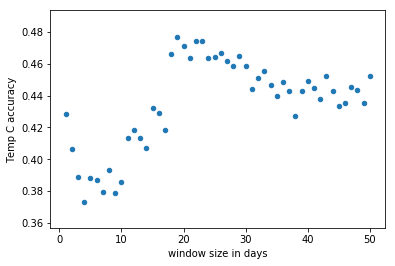

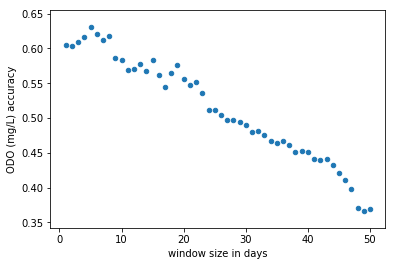

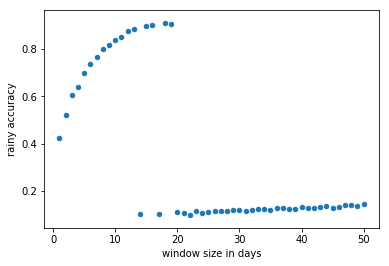

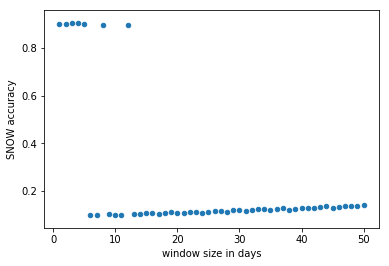

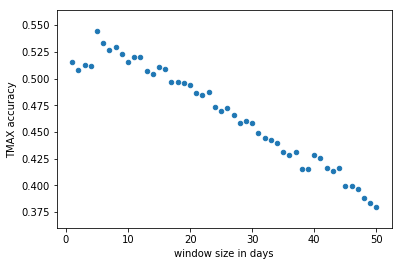

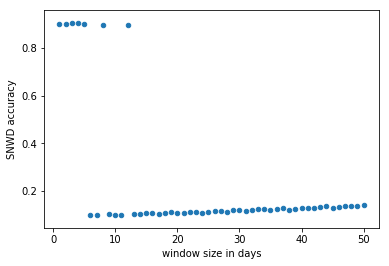

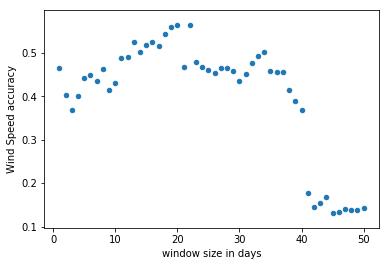

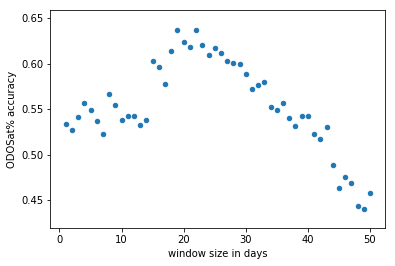

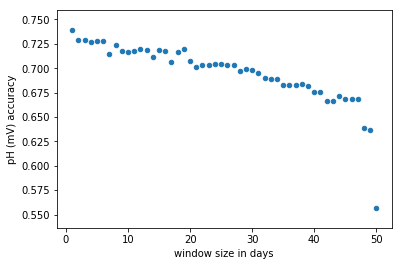

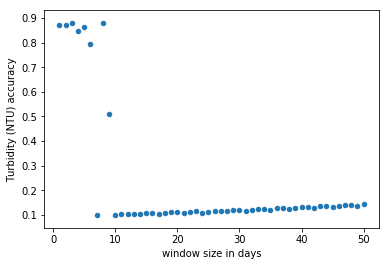

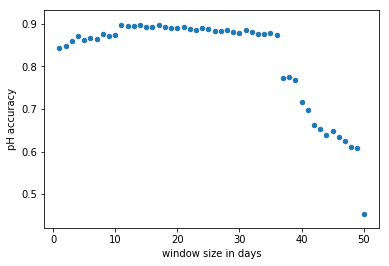

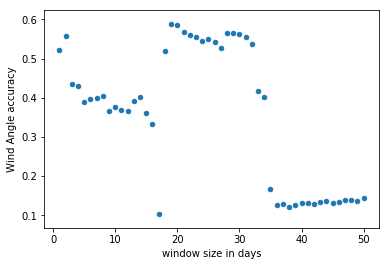

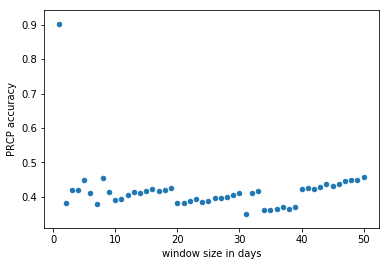

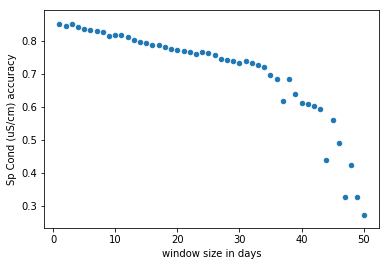

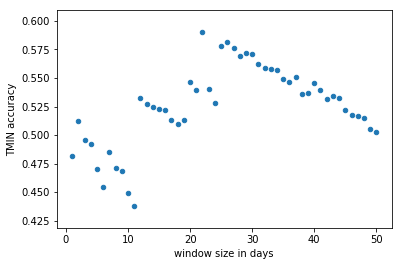

In [41]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Custom Window Size
Create a greedy model using the best custom window sizes found above.

In [42]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, x_win in best_x_windows.items():
    print(col, x_win)
    parameters[col] = {'x_win_size':x_win}

# Windowize
print("Windowizing 2017 data sets")
train = hf.windowize(train_dfs[0], 'datetime', 
                     target_column, custom_parameters=parameters)
for i in range(1, len(train_dfs)):
    train = train.append(hf.windowize(train_dfs[i], 'datetime', 
                         target_column, custom_parameters=parameters))
    print("Windowizing 2018 data sets")
test = hf.windowize(test_dfs[0], 'datetime', 
                    target_column, custom_parameters=parameters)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(test_dfs[i], 'datetime', 
                        target_column, custom_parameters=parameters))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()



Temp C 19 days 00:00:00
ODO (mg/L) 5 days 00:00:00
rainy 18 days 00:00:00
SNOW 3 days 00:00:00
TMAX 5 days 00:00:00
SNWD 3 days 00:00:00
Wind Speed 20 days 00:00:00
ODOSat% 22 days 00:00:00
pH (mV) 1 days 00:00:00
Turbidity (NTU) 8 days 00:00:00
pH 11 days 00:00:00
Wind Angle 19 days 00:00:00
PRCP 1 days 00:00:00
Sp Cond (uS/cm) 1 days 00:00:00
TMIN 22 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Com

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.3904320987654321
Recall: 0.9459459459459459
Precision 0.15184381778741865
Confusion Matrix:
 [[183 391]
 [  4  70]]

Training model with: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5416666666666666
Recall: 0.7567567567567568
Precision 0.16716417910447762
Confusion Matrix:
 [[295 279]
 [ 18  56]]

Training model with: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.11419753086419752
Recall: 1.0
Precision 0.11419753086419752
Confusion Matrix:
 [[  0 574]
 [  0  74]]

Training model with: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.11419753086419752
Recall: 1.0
Precision 0.11419753086419752
Confusion Matrix:
 [[  0 574]
 [  0  74]]

Training model with: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.3888888888888889
Recall: 0.9459459459459459
Precision 0.15151515151515152
Confusion Matrix:
 [[182 392]
 [  4  70]]

Training model with: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.11419753086419752
Recall: 1.0
Precision 0.11419753086419752
Confusion Matrix:
 [[  0 574]
 [  0  74]]

Training model with: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.4012345679012346
Recall: 1.0
Precision 0.16017316017316016
Confusion Matrix:
 [[186 388]
 [  0  74]]

Training model with: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5493827160493827
Recall: 0.7567567567567568
Precision 0.1696969696969697
Confusion Matrix:
 [[300 274]
 [ 18  56]]

Training model with: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6450617283950617
Recall: 0.40540540540540543
Precision 0.1388888888888889
Confusion Matrix:
 [[388 186]
 [ 44  30]]

Training model with: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.11419753086419752
Recall: 1.0
Precision 0.11419753086419752
Confusion Matrix:
 [[  0 574]
 [  0  74]]

Training model with: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.8564814814814815
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[555  19]
 [ 74   0]]

Training model with: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5416666666666666
Recall: 0.9459459459459459
Precision 0.1928374655647383
Confusion Matrix:
 [[281 293]
 [  4  70]]

Training model with: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.11419753086419752
Recall: 1.0
Precision 0.11419753086419752
Confusion Matrix:
 [[  0 574]
 [  0  74]]

Training model with: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.8395061728395061
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[544  30]
 [ 74   0]]

Training model with: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5138888888888888
Recall: 0.9459459459459459
Precision 0.1837270341207349
Confusion Matrix:
 [[263 311]
 [  4  70]]

pH metric value: 0.8564814814814815
Sp Cond (uS/cm) metric value: 0.8395061728395061
pH (mV) metric value: 0.6450617283950617
ODOSat% metric value: 0.5493827160493827
ODO (mg/L) metric value: 0.5416666666666666
Wind Angle metric value: 0.5416666666666666
TMIN metric value: 0.5138888888888888
Wind Speed metric value: 0.4012345679012346
Temp C metric value: 0.3904320987654321
TMAX metric value: 0.3888888888888889
rainy metric value: 0.11419753086419752
SNOW metric value: 0.11419753086419752
SNWD metric value: 0.11419753086419752
Turbidity (NTU) metric value: 0.11419753086419752
PRCP metric value: 0.11419753086419752


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Null model accuracy 0.11419753086419752
Null model  recall: 1.0
Null model  precision: 0.11419753086419752
Null model  confusion matrix:
 [[  0 574]
 [  0  74]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'PRCP']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'PRCP']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8564814814814815
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Test model accuracy: 0.8765432098765432
Test model recall: 0.013513513513513514
Test model precision: 0.125

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8796296296296297
Test model recall: 0.40540540540540543
Test model precision: 0.46875

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8888888888888888
Test model recall: 0.40540540540540543
Test model precision: 0.5172413793103449

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8734567901234568
Test model recall: 0.43243243243243246
Test model precision: 0.4444444444444444

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8179012345679012
Test model recall: 0.5135135135135135
Test model precision: 0.31666666666666665

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8549382716049383
Test model recall: 0.581081081081081
Test model precision: 0.4056603773584906

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8364197530864198
Test model recall: 0.6081081081081081
Test model precision: 0.36885245901639346

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8703703703703703
Test model recall: 0.44594594594594594
Test model precision: 0.4342105263157895

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873456790123457
Test model recall: 0.40540540540540543
Test model precision: 0.5084745762711864

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8888888888888888
Test model recall: 0.40540540540540543
Test model precision: 0.5172413793103449

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8888888888888888
Test model recall: 0.40540540540540543
Test model precision: 0.5172413793103449

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8549382716049383
Test model recall: 0.44594594594594594
Test model precision: 0.38372093023255816

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8842592592592593
Test model recall: 0.40540540540540543
Test model precision: 0.4918032786885246

Final greedy columns: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)']
Final greedy accuracy 0.8888888888888888
Final greedy recall: 0.40540540540540543
Final greedy precision: 0.5172413793103449
Final greedy confusion matrix:
 [[546  28]
 [ 44  30]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6715643906655142
Test model recall: 0.45585874799357945
Test model precision: 0.8738461538461538
Final greedy confusion matrix:
 [[493  41]
 [339 284]]
accuracy 0.8888888888888888
recall 0.40540540540540543
precision 0.5172413793103449



In [43]:
print("Cross validate:")
base_columns = ['TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)']

print("test vs train:")
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

Cross validate:
test vs train:


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6464995678478824
recall 0.36918138041733545
precision 0.9349593495934959



Performance of the model and the columns it selects seems to be largely dependent on the buey location.

## Greedy Window Size
Find a single optimal window size for all features

In [44]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data sets")
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data sets")
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.9024081115335868
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[712   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'pH', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'TMAX', 'TMIN', 'Wind Speed', 'Temp C', 'rainy']
adjusted sorted_columns: ['SNOW', 'SNWD', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'pH', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'TMAX', 'TMIN', 'Wind Speed', 'Temp C', 'rainy']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']
Test model accuracy: 0.8719898605830165
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.85297845373891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.844106463878327
Test model recall: 0.06493506493506493
Test model precision: 0.08928571428571429

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7389100126742713
Test model recall: 0.4155844155844156
Test model precision: 0.16580310880829016

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6045627376425855
Test model recall: 0.7272727272727273
Test model precision: 0.16138328530259366

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5335868187579215
Test model recall: 0.7662337662337663
Test model precision: 0.14425427872860636

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5209125475285171
Test model recall: 0.33766233766233766
Test model precision: 0.07365439093484419

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5158428390367554
Test model recall: 0.961038961038961
Test model precision: 0.16335540838852097

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4816223067173637
Test model recall: 0.8831168831168831
Test model precision: 0.1452991452991453

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.46894803548795944
Test model recall: 0.6493506493506493
Test model precision: 0.11312217194570136

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.42839036755386567
Test model recall: 0.987012987012987
Test model precision: 0.1444866920152091

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.42585551330798477
Test model recall: 0.5974025974025974
Test model precision: 0.09829059829059829

Final greedy columns: []
Final greedy accuracy 0.9024081115335868
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[712   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9024081115335868
recall 0.0
precision 0.0

Better Accuracy Found
current x window 2 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target window

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.9016602809706258
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[706   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'rainy', 'TMIN', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP']
adjusted sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'rainy', 'TMIN', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']
Test model accuracy: 0.8710089399744572
Test model recall: 0.012987012987012988
Test model precision: 0.038461538461538464

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8492975734355045
Test model recall: 0.09090909090909091
Test model precision: 0.12727272727272726

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8454661558109834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7292464878671775
Test model recall: 0.42857142857142855
Test model precision: 0.16417910447761194

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6040868454661558
Test model recall: 0.7402597402597403
Test model precision: 0.1642651296829971

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5568326947637292
Test model recall: 0.5194805194805194
Test model precision: 0.11428571428571428

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5274584929757343
Test model recall: 0.8181818181818182
Test model precision: 0.15035799522673032

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5236270753512133
Test model recall: 0.6103896103896104
Test model precision: 0.12051282051282051

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.51213282247765
Test model recall: 0.961038961038961
Test model precision: 0.16335540838852097

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.508301404853129
Test model recall: 0.961038961038961
Test model precision: 0.16228070175438597

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4061302681992337
Test model recall: 1.0
Test model precision: 0.14206642066420663

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.40357598978288634
Test model recall: 0.6883116883116883
Test model precision: 0.10685483870967742

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3831417624521073
Test model recall: 0.8701298701298701
Test model precision: 0.12407407407407407

Final greedy columns: []
Final greedy accuracy 0.9016602809706258
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[706   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9016602809706258
recall 0.0
precision 0.0

current x window 3 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.9060489060489061
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[704   0]
 [ 73   0]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'rainy', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Angle', 'PRCP', 'Temp C', 'Wind Speed']
adjusted sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'rainy', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Angle', 'PRCP', 'Temp C', 'Wind Speed']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']
Test model accuracy: 0.8777348777348777
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8597168597168597
Test model recall: 0.1095890410958904
Test model precision: 0.15384615384615385

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.851994851994852
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7284427284427284
Test model recall: 0.4246575342465753
Test model precision: 0.155

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6087516087516087
Test model recall: 0.726027397260274
Test model precision: 0.1572700296735905

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6061776061776062
Test model recall: 0.5205479452054794
Test model precision: 0.12297734627831715

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5418275418275418
Test model recall: 0.7945205479452054
Test model precision: 0.14536340852130325

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5122265122265123
Test model recall: 0.9452054794520548
Test model precision: 0.1554054054054054

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4954954954954955
Test model recall: 0.958904109589041
Test model precision: 0.15250544662309368

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.435006435006435
Test model recall: 0.6575342465753424
Test model precision: 0.1038961038961039

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.42084942084942084
Test model recall: 0.9726027397260274
Test model precision: 0.13680154142581888

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3886743886743887
Test model recall: 0.9863013698630136
Test model precision: 0.13186813186813187

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3680823680823681
Test model recall: 0.9315068493150684
Test model precision: 0.12274368231046931

Final greedy columns: []
Final greedy accuracy 0.9060489060489061
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[704   0]
 [ 73   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9060489060489061
recall 0.0
precision 0.0

Better Accuracy Found
current x window 4 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.9031007751937985
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[699   0]
 [ 75   0]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'pH', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Angle', 'PRCP', 'Wind Speed', 'Temp C']
adjusted sorted_columns: ['SNOW', 'SNWD', 'pH', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Angle', 'PRCP', 'Wind Speed', 'Temp C']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.872093023255814
Test model recall: 0.08
Test model precision: 0.16666666666666666

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8527131782945736
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8436692506459949
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.727390180878553
Test model recall: 0.4266666666666667
Test model precision: 0.16

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6408268733850129
Test model recall: 0.4666666666666667
Test model precision: 0.1282051282051282

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6162790697674418
Test model recall: 0.6933333333333334
Test model precision: 0.15950920245398773

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5568475452196382
Test model recall: 0.7733333333333333
Test model precision: 0.15104166666666666

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5116279069767442
Test model recall: 0.92
Test model precision: 0.1564625850340136

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.49224806201550386
Test model recall: 0.92
Test model precision: 0.1513157894736842

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.43023255813953487
Test model recall: 0.6
Test model precision: 0.09868421052631579

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4198966408268734
Test model recall: 0.9466666666666667
Test model precision: 0.1375968992248062

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4005167958656331
Test model recall: 0.9466666666666667
Test model precision: 0.1337099811676083

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3733850129198966
Test model recall: 0.9733333333333334
Test model precision: 0.13129496402877697

Final greedy columns: []
Final greedy accuracy 0.9031007751937985
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[699   0]
 [ 75   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9031007751937985
recall 0.0
precision 0.0

current x window 5 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.8997395833333334
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[691   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'PRCP', 'Wind Speed', 'Temp C', 'Wind Angle']
adjusted sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'rainy', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'PRCP', 'Wind Speed', 'Temp C', 'Wind Angle']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']
Test model accuracy: 0.8645833333333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.86328125
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8424479166666666
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7278645833333334
Test model recall: 0.42857142857142855
Test model precision: 0.16666666666666666

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6979166666666666
Test model recall: 0.37662337662337664
Test model precision: 0.13615023474178403

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6302083333333334
Test model recall: 0.7272727272727273
Test model precision: 0.1755485893416928

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5494791666666666
Test model recall: 0.7792207792207793
Test model precision: 0.15424164524421594

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5442708333333334
Test model recall: 0.935064935064935
Test model precision: 0.17266187050359713

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4700520833333333
Test model recall: 0.935064935064935
Test model precision: 0.1518987341772152

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.44921875
Test model recall: 0.948051948051948
Test model precision: 0.1483739837398374

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.44140625
Test model recall: 0.948051948051948
Test model precision: 0.1465863453815261

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3880208333333333
Test model recall: 0.974025974025974
Test model precision: 0.13812154696132597

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3880208333333333
Test model recall: 0.5844155844155844
Test model precision: 0.09316770186335403

Final greedy columns: []
Final greedy accuracy 0.8997395833333334
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[691   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8997395833333334
recall 0.0
precision 0.0

current x window 6 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.09973753280839895
Null model  recall: 1.0
Null model  precision: 0.09973753280839895
Null model  confusion matrix:
 [[  0 686]
 [  0  76]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Wind Angle', 'Temp C', 'SNOW', 'SNWD']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Wind Angle', 'Temp C', 'SNOW', 'SNWD']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8661417322834646
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Test model accuracy: 0.8937007874015748
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Test model accuracy: 0.8818897637795275
Test model recall: 0.10526315789473684
Test model precision: 0.26666666666666666

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889763779527559
Test model recall: 0.3815789473684211
Test model precision: 0.4393939393939394

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8385826771653543
Test model recall: 0.618421052631579
Test model precision: 0.3333333333333333

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN']
Test model accuracy: 0.9015748031496063
Test model recall: 0.013157894736842105
Test model precision: 1.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.910761154855643
Test model recall: 0.13157894736842105
Test model precision: 0.8333333333333334

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.910761154855643
Test model recall: 0.13157894736842105
Test model precision: 0.8333333333333334

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9094488188976378
Test model recall: 0.11842105263157894
Test model precision: 0.8181818181818182

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9094488188976378
Test model recall: 0.17105263157894737
Test model precision: 0.6842105263157895

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.910761154855643
Test model recall: 0.13157894736842105
Test model precision: 0.8333333333333334

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.910761154855643
Test model recall: 0.13157894736842105
Test model precision: 0.8333333333333334

Final greedy columns: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed']
Final greedy accuracy 0.910761154855643
Final greedy recall: 0.13157894736842105
Final greedy precision: 0.8333333333333334
Final greedy confusion matrix:
 [[684   2]
 [ 66  10]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7941851568477429
Test model recall: 0.7972560975609756
Test model precision: 0.7936267071320182
Final greedy confusion matrix:
 [[515 136]
 [133 523]]
accuracy 0.910761154855643
recall 0.13157894736842105
precision 0.8333333333333334

Better Accuracy Found
current x window 7 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.09788359788359788
Null model  recall: 1.0
Null model  precision: 0.09788359788359788
Null model  confusion matrix:
 [[  0 682]
 [  0  74]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'TMAX', 'ODOSat%', 'TMIN', 'Wind Speed', 'Wind Angle', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'TMAX', 'ODOSat%', 'TMIN', 'Wind Speed', 'Wind Angle', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8650793650793651
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)']
Test model accuracy: 0.876984126984127
Test model recall: 0.04054054054054054
Test model precision: 0.12

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9007936507936508
Test model recall: 0.3918918918918919
Test model precision: 0.4915254237288136

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'ODOSat%']
Test model accuracy: 0.832010582010582
Test model recall: 0.6486486486486487
Test model precision: 0.3221476510067114

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9074074074074074
Test model recall: 0.05405405405405406
Test model precision: 1.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9074074074074074
Test model recall: 0.12162162162162163
Test model precision: 0.6428571428571429

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8888888888888888
Test model recall: 0.013513513513513514
Test model precision: 0.08333333333333333

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.91005291005291
Test model recall: 0.10810810810810811
Test model precision: 0.8

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9126984126984127
Test model recall: 0.10810810810810811
Test model precision: 1.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C', 'PRCP', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.906084656084656
Test model recall: 0.04054054054054054
Test model precision: 1.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.906084656084656
Test model recall: 0.04054054054054054
Test model precision: 1.0

Training model with: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C', 'PRCP', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8875661375661376
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH', 'Sp Cond (uS/cm)', 'TMIN', 'Temp C', 'PRCP']
Final greedy accuracy 0.9126984126984127
Final greedy recall: 0.10810810810810811
Final greedy precision: 1.0
Final greedy confusion matrix:
 [[682   0]
 [ 66   8]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7963105303612605
Test model recall: 0.8234398782343988
Test model precision: 0.7840579710144927
Final greedy confusion matrix:
 [[495 149]
 [116 541]]
accuracy 0.9126984126984127
recall 0.10810810810810811
precision 1.0

Better Accuracy Found
current x window 8 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extracti

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10225763612217796
Null model  recall: 1.0
Null model  precision: 0.10225763612217796
Null model  confusion matrix:
 [[  0 676]
 [  0  77]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Wind Angle', 'Temp C']
adjusted sorted_columns: ['SNOW', 'SNWD', 'Turbidity (NTU)', 'pH', 'Sp Cond (uS/cm)', 'rainy', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Wind Angle', 'Temp C']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['SNOW', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'Turbidity (NTU)']
Test model accuracy: 0.17397078353253653
Test model recall: 1.0
Test model precision: 0.11015736766809728

Training model with: ['SNOW', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'Sp Cond (uS/cm)']
Test model accuracy: 0.8326693227091634
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.799468791500664
Test model recall: 0.2597402597402597
Test model precision: 0.17543859649122806

Training model with: ['SNOW', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7264276228419655
Test model recall: 0.4155844155844156
Test model precision: 0.16580310880829016

Training model with: ['SNOW', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6188579017264276
Test model recall: 0.7272727272727273
Test model precision: 0.17391304347826086

Training model with: ['SNOW', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5683930942895087
Test model recall: 0.8051948051948052
Test model precision: 0.16666666666666666

Training model with: ['SNOW', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5298804780876494
Test model recall: 0.8701298701298701
Test model precision: 0.1630170316301703

Training model with: ['SNOW', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4714475431606906
Test model recall: 0.974025974025974
Test model precision: 0.1592356687898089

Training model with: ['SNOW', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.46215139442231074
Test model recall: 0.987012987012987
Test model precision: 0.15833333333333333

Training model with: ['SNOW', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.46215139442231074
Test model recall: 0.9090909090909091
Test model precision: 0.14957264957264957

Training model with: ['SNOW', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4063745019920319
Test model recall: 0.33766233766233766
Test model precision: 0.061611374407582936

Training model with: ['SNOW', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4316069057104914
Test model recall: 0.948051948051948
Test model precision: 0.14688128772635814

Final greedy columns: ['SNOW']
Final greedy accuracy 0.897742363877822
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[676   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.49961330239752516
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[646   0]
 [647   0]]
accuracy 0.897742363877822
recall 0.0
precision 0.0

current x window 9 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extrac

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10307898259705489
Null model  recall: 1.0
Null model  precision: 0.10307898259705489
Null model  confusion matrix:
 [[  0 670]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'Turbidity (NTU)', 'TMIN', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'SNOW', 'SNWD']
adjusted sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'Turbidity (NTU)', 'TMIN', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'SNOW', 'SNWD']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8714859437751004
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848728246318608
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848728246318608
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.85809906291834
Test model recall: 0.1038961038961039
Test model precision: 0.17777777777777778

Training model with: ['pH', 'rainy', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8540829986613119
Test model recall: 0.4025974025974026
Test model precision: 0.32978723404255317

Training model with: ['pH', 'rainy', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7911646586345381
Test model recall: 0.6753246753246753
Test model precision: 0.28415300546448086

Training model with: ['pH', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.85809906291834
Test model recall: 0.15584415584415584
Test model precision: 0.22641509433962265

Training model with: ['pH', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848728246318608
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8514056224899599
Test model recall: 0.12987012987012986
Test model precision: 0.18518518518518517

Training model with: ['pH', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8674698795180723
Test model recall: 0.09090909090909091
Test model precision: 0.19444444444444445

Training model with: ['pH', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8125836680053548
Test model recall: 0.07792207792207792
Test model precision: 0.08

Training model with: ['pH', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8487282463186078
Test model recall: 0.09090909090909091
Test model precision: 0.14

Training model with: ['pH', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8607764390896921
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848728246318608
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848728246318608
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH', 'rainy']
Final greedy accuracy 0.8848728246318608
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[661   9]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5902021772939346
Test model recall: 0.2684049079754601
Test model precision: 0.7777777777777778
Final greedy confusion matrix:
 [[584  50]
 [477 175]]
accuracy 0.8848728246318608
recall 0.0
precision 0.0

current x window 10 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting featu

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.09851551956815115
Null model  recall: 1.0
Null model  precision: 0.09851551956815115
Null model  confusion matrix:
 [[  0 668]
 [  0  73]]
base_columns: []
sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'TMIN', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8744939271255061
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8920377867746289
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.9014844804318488
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)']
Test model accuracy: 0.8623481781376519
Test model recall: 0.0273972602739726
Test model precision: 0.06060606060606061

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9082321187584346
Test model recall: 0.3835616438356164
Test model precision: 0.5490196078431373

Updating greedy model

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8083670715249662
Test model recall: 0.5068493150684932
Test model precision: 0.25874125874125875

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.873144399460189
Test model recall: 0.4520547945205479
Test model precision: 0.3793103448275862

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8178137651821862
Test model recall: 0.4657534246575342
Test model precision: 0.26153846153846155

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8866396761133604
Test model recall: 0.4383561643835616
Test model precision: 0.4266666666666667

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8839406207827261
Test model recall: 0.3561643835616438
Test model precision: 0.4

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8097165991902834
Test model recall: 0.5205479452054794
Test model precision: 0.2638888888888889

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9014844804318488
Test model recall: 0.410958904109589
Test model precision: 0.5

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9055330634278003
Test model recall: 0.3561643835616438
Test model precision: 0.5306122448979592

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9055330634278003
Test model recall: 0.3561643835616438
Test model precision: 0.5306122448979592

Training model with: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8974358974358975
Test model recall: 0.410958904109589
Test model precision: 0.47619047619047616

Final greedy columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'ODO (mg/L)']
Final greedy accuracy 0.9082321187584346
Final greedy recall: 0.3835616438356164
Final greedy precision: 0.5490196078431373
Final greedy confusion matrix:
 [[645  23]
 [ 45  28]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6453125
Test model recall: 0.36809815950920244
Test model precision: 0.851063829787234
Final greedy confusion matrix:
 [[586  42]
 [412 240]]
accuracy 0.9082321187584346
recall 0.3835616438356164
precision 0.5490196078431373

current x window 11 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmentin

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.1016260162601626
Null model  recall: 1.0
Null model  precision: 0.1016260162601626
Null model  confusion matrix:
 [[  0 663]
 [  0  75]]
base_columns: []
sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'Wind Speed', 'TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMAX', 'Wind Speed', 'TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy']
Test model accuracy: 0.8902439024390244
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8509485094850948
Test model recall: 0.16
Test model precision: 0.2033898305084746

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8848238482384824
Test model recall: 0.41333333333333333
Test model precision: 0.4305555555555556

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7710027100271003
Test model recall: 0.6533333333333333
Test model precision: 0.2552083333333333

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8509485094850948
Test model recall: 0.14666666666666667
Test model precision: 0.19298245614035087

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8739837398373984
Test model recall: 0.16
Test model precision: 0.2857142857142857

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8401084010840109
Test model recall: 0.18666666666666668
Test model precision: 0.19718309859154928

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8333333333333334
Test model recall: 0.10666666666666667
Test model precision: 0.125

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8089430894308943
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8590785907859079
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.8455284552845529
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH']
Final greedy accuracy 0.8983739837398373
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[663   0]
 [ 75   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5420267085624509
Test model recall: 0.09627329192546584
Test model precision: 0.9841269841269841
Final greedy confusion matrix:
 [[628   1]
 [582  62]]
accuracy 0.8983739837398373
recall 0.0
precision 0.0

current x window 12 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feat

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.1051912568306011
Null model  recall: 1.0
Null model  precision: 0.1051912568306011
Null model  confusion matrix:
 [[  0 655]
 [  0  77]]
base_columns: []
sorted_columns: ['SNOW', 'SNWD', 'pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'Wind Angle', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNOW', 'SNWD', 'pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'Wind Angle', 'Turbidity (NTU)']
Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['SNOW', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'rainy']
Test model accuracy: 0.8756830601092896
Test model recall: 0.2987012987012987
Test model precision: 0.38333333333333336

Training model with: ['SNOW', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8114754098360656
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7295081967213115
Test model recall: 0.42857142857142855
Test model precision: 0.17647058823529413

Training model with: ['SNOW', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5737704918032787
Test model recall: 0.7402597402597403
Test model precision: 0.16332378223495703

Training model with: ['SNOW', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5437158469945356
Test model recall: 0.7792207792207793
Test model precision: 0.15915119363395225

Training model with: ['SNOW', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5327868852459017
Test model recall: 0.948051948051948
Test model precision: 0.17761557177615572

Training model with: ['SNOW', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5286885245901639
Test model recall: 0.948051948051948
Test model precision: 0.17632850241545894

Training model with: ['SNOW', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.505464480874317
Test model recall: 0.987012987012987
Test model precision: 0.17391304347826086

Training model with: ['SNOW', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4248633879781421
Test model recall: 0.948051948051948
Test model precision: 0.1489795918367347

Training model with: ['SNOW', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.412568306010929
Test model recall: 0.8831168831168831
Test model precision: 0.1390593047034765

Training model with: ['SNOW', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3756830601092896
Test model recall: 0.22077922077922077
Test model precision: 0.04106280193236715

Training model with: ['SNOW', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.1051912568306011
Test model recall: 1.0
Test model precision: 0.1051912568306011

Final greedy columns: ['SNOW']
Final greedy accuracy 0.894808743169399
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[655   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4976303317535545
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[630   0]
 [636   0]]
accuracy 0.894808743169399
recall 0.0
precision 0.0

current x window 13 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extrac

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.1046831955922865
Null model  recall: 1.0
Null model  precision: 0.1046831955922865
Null model  confusion matrix:
 [[  0 650]
 [  0  76]]
base_columns: []
sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'rainy', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'rainy']
Test model accuracy: 0.8925619834710744
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8292011019283747
Test model recall: 0.09210526315789473
Test model precision: 0.11290322580645161

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8884297520661157
Test model recall: 0.35526315789473684
Test model precision: 0.4576271186440678

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7892561983471075
Test model recall: 0.631578947368421
Test model precision: 0.2774566473988439

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.837465564738292
Test model recall: 0.13157894736842105
Test model precision: 0.16129032258064516

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8705234159779615
Test model recall: 0.18421052631578946
Test model precision: 0.30434782608695654

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8347107438016529
Test model recall: 0.09210526315789473
Test model precision: 0.1206896551724138

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8319559228650137
Test model recall: 0.09210526315789473
Test model precision: 0.11666666666666667

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8044077134986226
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898071625344353
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.8223140495867769
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH']
Final greedy accuracy 0.8953168044077136
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[650   0]
 [ 76   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5162827640984908
Test model recall: 0.04395604395604396
Test model precision: 1.0
Final greedy confusion matrix:
 [[622   0]
 [609  28]]
accuracy 0.8953168044077136
recall 0.0
precision 0.0

current x window 14 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10277777777777777
Null model  recall: 1.0
Null model  precision: 0.10277777777777777
Null model  confusion matrix:
 [[  0 646]
 [  0  74]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'TMAX', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'TMAX', 'Wind Speed', 'PRCP', 'Temp C', 'Wind Angle', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8277777777777777
Test model recall: 0.0945945945945946
Test model precision: 0.109375

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8902777777777777
Test model recall: 0.3783783783783784
Test model precision: 0.45901639344262296

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7847222222222222
Test model recall: 0.6756756756756757
Test model precision: 0.27624309392265195

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8388888888888889
Test model recall: 0.13513513513513514
Test model precision: 0.16129032258064516

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8319444444444445
Test model recall: 0.0945945945945946
Test model precision: 0.11475409836065574

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8763888888888889
Test model recall: 0.17567567567567569
Test model precision: 0.3170731707317073

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8041666666666667
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8402777777777778
Test model recall: 0.14864864864864866
Test model precision: 0.1746031746031746

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.8222222222222222
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH']
Final greedy accuracy 0.8972222222222223
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[646   0]
 [ 74   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.509976057462091
Test model recall: 0.03912363067292645
Test model precision: 1.0
Final greedy confusion matrix:
 [[614   0]
 [614  25]]
accuracy 0.8972222222222223
recall 0.0
precision 0.0

current x window 15 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target w

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10739191073919108
Null model  recall: 1.0
Null model  precision: 0.10739191073919108
Null model  confusion matrix:
 [[  0 640]
 [  0  77]]
base_columns: []
sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.899581589958159
Test model recall: 0.24675324675324675
Test model precision: 0.5757575757575758

Updating greedy model

Training model with: ['rainy', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8926080892608089
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'Sp Cond (uS/cm)']
Test model accuracy: 0.7949790794979079
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7280334728033473
Test model recall: 0.4155844155844156
Test model precision: 0.17582417582417584

Training model with: ['rainy', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6471408647140865
Test model recall: 0.7662337662337663
Test model precision: 0.20068027210884354

Training model with: ['rainy', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6122733612273361
Test model recall: 0.7532467532467533
Test model precision: 0.1829652996845426

Training model with: ['rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5230125523012552
Test model recall: 0.948051948051948
Test model precision: 0.17761557177615572

Training model with: ['rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5174337517433751
Test model recall: 1.0
Test model precision: 0.18203309692671396

Training model with: ['rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5104602510460251
Test model recall: 0.948051948051948
Test model precision: 0.1738095238095238

Training model with: ['rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4839609483960948
Test model recall: 0.948051948051948
Test model precision: 0.1662870159453303

Training model with: ['rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.41841004184100417
Test model recall: 0.8701298701298701
Test model precision: 0.14135021097046413

Training model with: ['rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.42398884239888424
Test model recall: 0.35064935064935066
Test model precision: 0.06923076923076923

Training model with: ['rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.899581589958159
Test model recall: 0.24675324675324675
Test model precision: 0.5757575757575758

Training model with: ['rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.899581589958159
Test model recall: 0.24675324675324675
Test model precision: 0.5757575757575758

Training model with: ['rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11297071129707113
Test model recall: 1.0
Test model precision: 0.10799438990182328

Final greedy columns: ['rainy']
Final greedy accuracy 0.899581589958159
Final greedy recall: 0.24675324675324675
Final greedy precision: 0.5757575757575758
Final greedy confusion matrix:
 [[626  14]
 [ 58  19]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5148594377510041
Test model recall: 0.28525641025641024
Test model precision: 0.5297619047619048
Final greedy confusion matrix:
 [[463 158]
 [446 178]]
accuracy 0.899581589958159
recall 0.24675324675324675
precision 0.5757575757575758

current x window 16 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10829817158931083
Null model  recall: 1.0
Null model  precision: 0.10829817158931083
Null model  confusion matrix:
 [[  0 634]
 [  0  77]]
base_columns: []
sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'Wind Angle', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9029535864978903
Test model recall: 0.24675324675324675
Test model precision: 0.6333333333333333

Updating greedy model

Training model with: ['rainy', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8917018284106891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'Sp Cond (uS/cm)']
Test model accuracy: 0.790436005625879
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7229254571026723
Test model recall: 0.42857142857142855
Test model precision: 0.1774193548387097

Training model with: ['rainy', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6483825597749648
Test model recall: 0.7532467532467533
Test model precision: 0.20069204152249134

Training model with: ['rainy', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5963431786216596
Test model recall: 0.7402597402597403
Test model precision: 0.17592592592592593

Training model with: ['rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5260196905766527
Test model recall: 1.0
Test model precision: 0.1859903381642512

Training model with: ['rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5218002812939522
Test model recall: 0.961038961038961
Test model precision: 0.18004866180048662

Training model with: ['rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.509142053445851
Test model recall: 0.961038961038961
Test model precision: 0.1761904761904762

Training model with: ['rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.49226441631504925
Test model recall: 0.961038961038961
Test model precision: 0.1712962962962963

Training model with: ['rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3558368495077356
Test model recall: 0.8961038961038961
Test model precision: 0.1329479768786127

Training model with: ['rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.44163150492264414
Test model recall: 0.5324675324675324
Test model precision: 0.10199004975124377

Training model with: ['rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9029535864978903
Test model recall: 0.24675324675324675
Test model precision: 0.6333333333333333

Training model with: ['rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9029535864978903
Test model recall: 0.24675324675324675
Test model precision: 0.6333333333333333

Training model with: ['rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.10829817158931083
Test model recall: 1.0
Test model precision: 0.10829817158931083

Final greedy columns: ['rainy']
Final greedy accuracy 0.9029535864978903
Final greedy recall: 0.24675324675324675
Final greedy precision: 0.6333333333333333
Final greedy confusion matrix:
 [[623  11]
 [ 58  19]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5145395799676898
Test model recall: 0.2718600953895072
Test model precision: 0.5445859872611465
Final greedy confusion matrix:
 [[466 143]
 [458 171]]
accuracy 0.9029535864978903
recall 0.24675324675324675
precision 0.6333333333333333

current x window 17 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10354609929078014
Null model  recall: 1.0
Null model  precision: 0.10354609929078014
Null model  confusion matrix:
 [[  0 632]
 [  0  73]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'Wind Angle']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'Wind Angle']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8127659574468085
Test model recall: 0.0273972602739726
Test model precision: 0.031746031746031744

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8056737588652483
Test model recall: 0.547945205479452
Test model precision: 0.2777777777777778

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8836879432624114
Test model recall: 0.3698630136986301
Test model precision: 0.42857142857142855

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8581560283687943
Test model recall: 0.1780821917808219
Test model precision: 0.24528301886792453

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8226950354609929
Test model recall: 0.136986301369863
Test model precision: 0.1388888888888889

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8184397163120567
Test model recall: 0.1095890410958904
Test model precision: 0.11267605633802817

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.825531914893617
Test model recall: 0.1780821917808219
Test model precision: 0.17105263157894737

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8028368794326242
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7914893617021277
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8709219858156029
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH']
Final greedy accuracy 0.8964539007092198
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[632   0]
 [ 73   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4878246753246753
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[601   0]
 [631   0]]
accuracy 0.8964539007092198
recall 0.0
precision 0.0

current x window 18 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10683760683760683
Null model  recall: 1.0
Null model  precision: 0.10683760683760683
Null model  confusion matrix:
 [[  0 627]
 [  0  75]]
base_columns: []
sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9116809116809117
Test model recall: 0.22666666666666666
Test model precision: 0.8095238095238095

Updating greedy model

Training model with: ['rainy', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'Sp Cond (uS/cm)']
Test model accuracy: 0.7834757834757835
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7279202279202279
Test model recall: 0.4266666666666667
Test model precision: 0.17777777777777778

Training model with: ['rainy', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6581196581196581
Test model recall: 0.76
Test model precision: 0.20430107526881722

Training model with: ['rainy', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5954415954415955
Test model recall: 0.7333333333333333
Test model precision: 0.1724137931034483

Training model with: ['rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5427350427350427
Test model recall: 1.0
Test model precision: 0.1893939393939394

Training model with: ['rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8176638176638177
Test model recall: 0.22666666666666666
Test model precision: 0.19540229885057472

Training model with: ['rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.50997150997151
Test model recall: 0.9466666666666667
Test model precision: 0.17274939172749393

Training model with: ['rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.49715099715099714
Test model recall: 0.9466666666666667
Test model precision: 0.16904761904761906

Training model with: ['rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.48717948717948717
Test model recall: 0.9466666666666667
Test model precision: 0.16627634660421545

Training model with: ['rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3732193732193732
Test model recall: 0.8666666666666667
Test model precision: 0.13131313131313133

Training model with: ['rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9116809116809117
Test model recall: 0.22666666666666666
Test model precision: 0.8095238095238095

Training model with: ['rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9116809116809117
Test model recall: 0.22666666666666666
Test model precision: 0.8095238095238095

Training model with: ['rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.10683760683760683
Test model recall: 1.0
Test model precision: 0.10683760683760683

Final greedy columns: ['rainy']
Final greedy accuracy 0.9116809116809117
Final greedy recall: 0.22666666666666666
Final greedy precision: 0.8095238095238095
Final greedy confusion matrix:
 [[623   4]
 [ 58  17]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5175510204081633
Test model recall: 0.24398073836276082
Test model precision: 0.5588235294117647
Final greedy confusion matrix:
 [[482 120]
 [471 152]]
accuracy 0.9116809116809117
recall 0.22666666666666666
precision 0.8095238095238095

current x window 19 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions..

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11063218390804598
Null model  recall: 1.0
Null model  precision: 0.11063218390804598
Null model  confusion matrix:
 [[  0 619]
 [  0  77]]
base_columns: []
sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['rainy', 'pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'ODO (mg/L)', 'Wind Speed', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9080459770114943
Test model recall: 0.18181818181818182
Test model precision: 0.9333333333333333

Updating greedy model

Training model with: ['rainy', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'Sp Cond (uS/cm)']
Test model accuracy: 0.7772988505747126
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7270114942528736
Test model recall: 0.4025974025974026
Test model precision: 0.17714285714285713

Training model with: ['rainy', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6752873563218391
Test model recall: 0.7532467532467533
Test model precision: 0.2188679245283019

Training model with: ['rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7658045977011494
Test model recall: 0.18181818181818182
Test model precision: 0.12280701754385964

Training model with: ['rainy', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.625
Test model recall: 0.7272727272727273
Test model precision: 0.1891891891891892

Training model with: ['rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5675287356321839
Test model recall: 1.0
Test model precision: 0.2037037037037037

Training model with: ['rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5129310344827587
Test model recall: 0.948051948051948
Test model precision: 0.17892156862745098

Training model with: ['rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4956896551724138
Test model recall: 0.948051948051948
Test model precision: 0.1738095238095238

Training model with: ['rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4942528735632184
Test model recall: 0.948051948051948
Test model precision: 0.17339667458432304

Training model with: ['rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.382183908045977
Test model recall: 0.8831168831168831
Test model precision: 0.1390593047034765

Training model with: ['rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9080459770114943
Test model recall: 0.18181818181818182
Test model precision: 0.9333333333333333

Training model with: ['rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9080459770114943
Test model recall: 0.18181818181818182
Test model precision: 0.9333333333333333

Training model with: ['rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11063218390804598
Test model recall: 1.0
Test model precision: 0.11063218390804598

Final greedy columns: ['rainy']
Final greedy accuracy 0.9080459770114943
Final greedy recall: 0.18181818181818182
Final greedy precision: 0.9333333333333333
Final greedy confusion matrix:
 [[618   1]
 [ 63  14]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5238095238095238
Test model recall: 0.23414634146341465
Test model precision: 0.5691699604743083
Final greedy confusion matrix:
 [[494 109]
 [471 144]]
accuracy 0.9080459770114943
recall 0.18181818181818182
precision 0.9333333333333333

current x window 20 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions..

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11014492753623188
Null model  recall: 1.0
Null model  precision: 0.11014492753623188
Null model  confusion matrix:
 [[  0 614]
 [  0  76]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'Wind Speed', 'ODO (mg/L)', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'Wind Speed', 'ODO (mg/L)', 'TMIN', 'TMAX', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8028985507246377
Test model recall: 0.013157894736842105
Test model precision: 0.016129032258064516

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.808695652173913
Test model recall: 0.5
Test model precision: 0.2878787878787879

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8478260869565217
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8521739130434782
Test model recall: 0.17105263157894737
Test model precision: 0.25

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8753623188405797
Test model recall: 0.34210526315789475
Test model precision: 0.41935483870967744

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8014492753623188
Test model recall: 0.09210526315789473
Test model precision: 0.09333333333333334

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8347826086956521
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8043478260869565
Test model recall: 0.15789473684210525
Test model precision: 0.14457831325301204

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7956521739130434
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8724637681159421
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.763768115942029
Test model recall: 0.09210526315789473
Test model precision: 0.06930693069306931

Final greedy columns: ['pH']
Final greedy accuracy 0.8898550724637682
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[614   0]
 [ 76   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4880264244426094
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[591   0]
 [620   0]]
accuracy 0.8898550724637682
recall 0.0
precision 0.0

current x window 21 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10818713450292397
Null model  recall: 1.0
Null model  precision: 0.10818713450292397
Null model  confusion matrix:
 [[  0 610]
 [  0  74]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'ODO (mg/L)', 'TMIN', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'ODO (mg/L)', 'TMIN', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8918128654970761
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8918128654970761
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8011695906432749
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7997076023391813
Test model recall: 0.527027027027027
Test model precision: 0.2765957446808511

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.847953216374269
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.881578947368421
Test model recall: 0.36486486486486486
Test model precision: 0.4426229508196721

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7953216374269005
Test model recall: 0.08108108108108109
Test model precision: 0.07692307692307693

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8128654970760234
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.847953216374269
Test model recall: 0.17567567567567569
Test model precision: 0.23214285714285715

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7982456140350878
Test model recall: 0.16216216216216217
Test model precision: 0.13636363636363635

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7953216374269005
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8786549707602339
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8918128654970761
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8918128654970761
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7543859649122807
Test model recall: 0.10810810810810811
Test model precision: 0.07272727272727272

Final greedy columns: ['pH']
Final greedy accuracy 0.8918128654970761
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[610   0]
 [ 74   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4829875518672199
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[582   0]
 [623   0]]
accuracy 0.8918128654970761
recall 0.0
precision 0.0

current x window 22 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.1130690161527166
Null model  recall: 1.0
Null model  precision: 0.1130690161527166
Null model  confusion matrix:
 [[  0 604]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'PRCP', 'SNOW', 'SNWD', 'Turbidity (NTU)', 'rainy']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.7973568281938326
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7929515418502202
Test model recall: 0.5324675324675324
Test model precision: 0.2808219178082192

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7870778267254038
Test model recall: 0.09090909090909091
Test model precision: 0.08536585365853659

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8370044052863436
Test model recall: 0.15584415584415584
Test model precision: 0.20689655172413793

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8414096916299559
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8781204111600588
Test model recall: 0.37662337662337664
Test model precision: 0.453125

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8325991189427313
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7900146842878121
Test model recall: 0.16883116883116883
Test model precision: 0.14130434782608695

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7914831130690162
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7562408223201175
Test model recall: 0.07792207792207792
Test model precision: 0.0594059405940594

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8781204111600588
Test model recall: 0.0
Test model precision: 0.0

Final greedy columns: ['pH']
Final greedy accuracy 0.8869309838472834
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[604   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4878863826232247
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[584   0]
 [613   0]]
accuracy 0.8869309838472834
recall 0.0
precision 0.0

current x window 23 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11407407407407408
Null model  recall: 1.0
Null model  precision: 0.11407407407407408
Null model  confusion matrix:
 [[  0 598]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.802962962962963
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7822222222222223
Test model recall: 0.5194805194805194
Test model precision: 0.26666666666666666

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8355555555555556
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7733333333333333
Test model recall: 0.07792207792207792
Test model precision: 0.06818181818181818

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8725925925925926
Test model recall: 0.35064935064935066
Test model precision: 0.42857142857142855

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8192592592592592
Test model recall: 0.18181818181818182
Test model precision: 0.1917808219178082

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7762962962962963
Test model recall: 0.14285714285714285
Test model precision: 0.11458333333333333

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7911111111111111
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.88
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7525925925925926
Test model recall: 0.07792207792207792
Test model precision: 0.058823529411764705

Final greedy columns: ['pH']
Final greedy accuracy 0.8859259259259259
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[598   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4789915966386555
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[570   0]
 [620   0]]
accuracy 0.8859259259259259
recall 0.0
precision 0.0

current x window 24 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.10911808669656203
Null model  recall: 1.0
Null model  precision: 0.10911808669656203
Null model  confusion matrix:
 [[  0 596]
 [  0  73]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'Wind Angle', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.890881913303438
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.890881913303438
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8086696562032885
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7982062780269058
Test model recall: 0.5068493150684932
Test model precision: 0.27205882352941174

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8400597907324364
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7713004484304933
Test model recall: 0.0410958904109589
Test model precision: 0.03488372093023256

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.874439461883408
Test model recall: 0.3424657534246575
Test model precision: 0.4098360655737705

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.828101644245142
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8340807174887892
Test model recall: 0.1780821917808219
Test model precision: 0.203125

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7817638266068759
Test model recall: 0.1643835616438356
Test model precision: 0.12371134020618557

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7922272047832586
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8878923766816144
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.890881913303438
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.890881913303438
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7443946188340808
Test model recall: 0.1095890410958904
Test model precision: 0.07017543859649122

Final greedy columns: ['pH']
Final greedy accuracy 0.890881913303438
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[596   0]
 [ 73   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.47297297297297297
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[560   0]
 [624   0]]
accuracy 0.890881913303438
recall 0.0
precision 0.0

current x window 25 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11261261261261261
Null model  recall: 1.0
Null model  precision: 0.11261261261261261
Null model  confusion matrix:
 [[  0 591]
 [  0  75]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8048048048048048
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7897897897897898
Test model recall: 0.49333333333333335
Test model precision: 0.26618705035971224

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7357357357357357
Test model recall: 0.18666666666666668
Test model precision: 0.10852713178294573

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8348348348348348
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8723723723723724
Test model recall: 0.3466666666666667
Test model precision: 0.41935483870967744

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8018018018018018
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7702702702702703
Test model recall: 0.16
Test model precision: 0.11764705882352941

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8288288288288288
Test model recall: 0.17333333333333334
Test model precision: 0.2

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7867867867867868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858858858858859
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7372372372372372
Test model recall: 0.10666666666666667
Test model precision: 0.06896551724137931

Final greedy columns: ['pH']
Final greedy accuracy 0.8873873873873874
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[591   0]
 [ 75   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4749362786745964
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[559   0]
 [618   0]]
accuracy 0.8873873873873874
recall 0.0
precision 0.0

current x window 26 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11666666666666667
Null model  recall: 1.0
Null model  precision: 0.11666666666666667
Null model  confusion matrix:
 [[  0 583]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8227272727272728
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7893939393939394
Test model recall: 0.5064935064935064
Test model precision: 0.2785714285714286

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6984848484848485
Test model recall: 0.38961038961038963
Test model precision: 0.16483516483516483

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8303030303030303
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8681818181818182
Test model recall: 0.33766233766233766
Test model precision: 0.41935483870967744

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7909090909090909
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7545454545454545
Test model recall: 0.14285714285714285
Test model precision: 0.102803738317757

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8181818181818182
Test model recall: 0.15584415584415584
Test model precision: 0.1791044776119403

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7803030303030303
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7272727272727273
Test model recall: 0.09090909090909091
Test model precision: 0.05982905982905983

Final greedy columns: ['pH']
Final greedy accuracy 0.8833333333333333
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[583   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.4752136752136752
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[556   0]
 [614   0]]
accuracy 0.8833333333333333
recall 0.0
precision 0.0

current x window 27 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extra

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.1162079510703364
Null model  recall: 1.0
Null model  precision: 0.1162079510703364
Null model  confusion matrix:
 [[  0 578]
 [  0  76]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8226299694189603
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7859327217125383
Test model recall: 0.5
Test model precision: 0.2714285714285714

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6972477064220184
Test model recall: 0.47368421052631576
Test model precision: 0.18556701030927836

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8134556574923547
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8669724770642202
Test model recall: 0.32894736842105265
Test model precision: 0.4098360655737705

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7844036697247706
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8226299694189603
Test model recall: 0.15789473684210525
Test model precision: 0.1875

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7568807339449541
Test model recall: 0.18421052631578946
Test model precision: 0.12612612612612611

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7737003058103975
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7247706422018348
Test model recall: 0.10526315789473684
Test model precision: 0.06666666666666667

Final greedy columns: ['pH']
Final greedy accuracy 0.8837920489296636
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[578   0]
 [ 76   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.46689595872742906
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[543   0]
 [620   0]]
accuracy 0.8837920489296636
recall 0.0
precision 0.0

current x window 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extr

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11419753086419752
Null model  recall: 1.0
Null model  precision: 0.11419753086419752
Null model  confusion matrix:
 [[  0 574]
 [  0  74]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Wind Speed', 'Temp C', 'TMAX', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Wind Speed', 'Temp C', 'TMAX', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8271604938271605
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7870370370370371
Test model recall: 0.527027027027027
Test model precision: 0.2746478873239437

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6851851851851852
Test model recall: 0.6081081081081081
Test model precision: 0.20454545454545456

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8240740740740741
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8734567901234568
Test model recall: 0.35135135135135137
Test model precision: 0.43333333333333335

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8209876543209876
Test model recall: 0.14864864864864866
Test model precision: 0.171875

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7299382716049383
Test model recall: 0.20270270270270271
Test model precision: 0.11450381679389313

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.779320987654321
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7731481481481481
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7114197530864198
Test model recall: 0.02702702702702703
Test model precision: 0.017094017094017096

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7160493827160493
Test model recall: 0.13513513513513514
Test model precision: 0.07692307692307693

Final greedy columns: ['pH']
Final greedy accuracy 0.8858024691358025
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[574   0]
 [ 74   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.46153846153846156
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[534   0]
 [623   0]]
accuracy 0.8858024691358025
recall 0.0
precision 0.0

current x window 29 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extr

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.11937984496124031
Null model  recall: 1.0
Null model  precision: 0.11937984496124031
Null model  confusion matrix:
 [[  0 568]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8155038759689922
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7798449612403101
Test model recall: 0.5324675324675324
Test model precision: 0.2789115646258503

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6511627906976745
Test model recall: 0.6883116883116883
Test model precision: 0.20866141732283464

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.827906976744186
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8697674418604651
Test model recall: 0.36363636363636365
Test model precision: 0.4444444444444444

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7147286821705426
Test model recall: 0.23376623376623376
Test model precision: 0.1258741258741259

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7674418604651163
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8186046511627907
Test model recall: 0.15584415584415584
Test model precision: 0.1875

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7689922480620155
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6961240310077519
Test model recall: 0.025974025974025976
Test model precision: 0.016260162601626018

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.7131782945736435
Test model recall: 0.14285714285714285
Test model precision: 0.08461538461538462

Final greedy columns: ['pH']
Final greedy accuracy 0.8806201550387597
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[568   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.46649260226283723
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[536   0]
 [613   0]]
accuracy 0.8806201550387597
recall 0.0
precision 0.0

current x window 30 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extr

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

Null model accuracy 0.12050078247261346
Null model  recall: 1.0
Null model  precision: 0.12050078247261346
Null model  confusion matrix:
 [[  0 562]
 [  0  77]]
base_columns: []
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Updating greedy model

Training model with: ['pH', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'pH (mV)']
Test model accuracy: 0.8075117370892019
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7730829420970265
Test model recall: 0.5064935064935064
Test model precision: 0.2671232876712329

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6322378716744914
Test model recall: 0.7272727272727273
Test model precision: 0.2074074074074074

Training model with: ['pH', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8247261345852895
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.863849765258216
Test model recall: 0.33766233766233766
Test model precision: 0.41935483870967744

Training model with: ['pH', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7057902973395931
Test model recall: 0.2987012987012987
Test model precision: 0.1464968152866242

Training model with: ['pH', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7636932707355243
Test model recall: 0.012987012987012988
Test model precision: 0.013157894736842105

Training model with: ['pH', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8028169014084507
Test model recall: 0.18181818181818182
Test model precision: 0.18181818181818182

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.758998435054773
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6635367762128326
Test model recall: 0.1038961038961039
Test model precision: 0.05194805194805195

Training model with: ['pH', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH', 'Turbidity (NTU)']
Test model accuracy: 0.6807511737089202
Test model recall: 0.1038961038961039
Test model precision: 0.055944055944055944

Final greedy columns: ['pH']
Final greedy accuracy 0.8794992175273866
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[562   0]
 [ 77   0]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.45709281961471104
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[522   0]
 [620   0]]
accuracy 0.8794992175273866
recall 0.0
precision 0.0



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

best accuracy 0.9126984126984127
best recall 0.10810810810810811
best precision 1.0
best x window 7 days 00:00:00


In [50]:
# TEST FOR PAPER
base_columns = ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
current_x_window = pd.Timedelta(28, unit='d') 

# Windowize
print("current x window", current_x_window)
print("Windowizing 2017 data sets")
train = hf.windowize(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=current_x_window, y_win_size=current_y_window)
for i in range(1, len(train_dfs)):
    train = train.append(hf.windowize(
        train_dfs[i], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window))
print("Windowizing 2018 data sets")
test = hf.windowize(
    test_dfs[0], 'datetime', target_column,
    x_win_size=current_x_window, y_win_size=current_y_window)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(
        test_dfs[i], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom', verbose=0)
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns, base_columns=base_columns )
accuracies.append(accuracy)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)

current x window 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
sorted_columns: ['pH', 'Sp Cond (uS/cm)', 'pH (mV)', 'ODOSat%', 'TMIN', 'Wind Angle', 'ODO (mg/L)', 'Wind Speed', 'Temp C', 'TMAX', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH (mV)', 'ODOSat%', 'Wind Angle', 'TMAX', 'PRCP', 'rainy', 'SNOW', 'SNWD', 'Turbidity (NTU)']
Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8811728395061729
Test model recall: 0.43243243243243246
Test model precision: 0.47761194029850745

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8780864197530864
Test model recall: 0.43243243243243246
Test model precision: 0.463768115942029

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8240740740740741
Test model recall: 0.7837837837837838
Test model precision: 0.3717948717948718

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7993827160493827
Test model recall: 0.8378378378378378
Test model precision: 0.34444444444444444

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8040123456790124
Test model recall: 0.8243243243243243
Test model precision: 0.3485714285714286

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7685185185185185
Test model recall: 0.8513513513513513
Test model precision: 0.3118811881188119

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'rainy', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7685185185185185
Test model recall: 0.8513513513513513
Test model precision: 0.3118811881188119

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7685185185185185
Test model recall: 0.8513513513513513
Test model precision: 0.3118811881188119

Training model with: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7453703703703703
Test model recall: 0.8513513513513513
Test model precision: 0.2903225806451613

Final greedy columns: ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Angle', 'TMAX', 'rainy']
Final greedy accuracy 0.7685185185185185
Final greedy recall: 0.8513513513513513
Final greedy precision: 0.3118811881188119
Final greedy confusion matrix:
 [[435 139]
 [ 11  63]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4157303370786517
Test model recall: 0.09630818619582665
Test model precision: 0.3468208092485549
Final greedy confusion matrix:
 [[421 113]
 [563  60]]
accuracy 0.7685185185185185
recall 0.8513513513513513
precision 0.3118811881188119


In [46]:
# Cross validate
base_columns = ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
# Windowize
print("current x window", best_x_window)
print("Windowizing 2017 data sets")
train = hf.windowize(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=best_x_window)
train = train.append(hf.windowize(
    train_dfs[1], 'datetime', target_column, 
    x_win_size=best_x_window))
print("Windowizing 2018 data sets")
test = hf.windowize(
    test_dfs[0], 'datetime', target_column,
    x_win_size=best_x_window)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(
        test_dfs[i], 'datetime', target_column,
        x_win_size=best_x_window))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom' )
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)

current x window 7 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7828843106180665
recall 0.6518218623481782
precision 0.7594339622641509


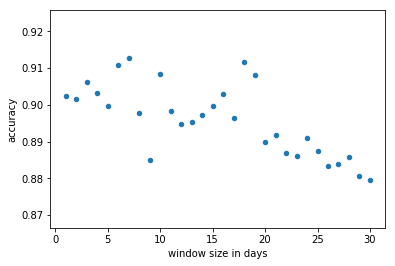

In [47]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")